## Efficientnet Adversarial Learning with RKD - WIDER (Class Reduced)

In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import copy
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet

from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss
# from models_package.models import Teacher, Student

# new libraries
from models_package.models import Teacher, Student, CustomResNet18
from torchvision import datasets, transforms, models
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof, load_wider
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss, DD_loss, AD_loss, RKDDistanceLoss, RKDAngleLoss
from utils.misc_tools_rkd import best_lr_rkd, rkd_train_teacher, rkd_train_student_with_distillation, rkd_test_model
from utils.compare_tools_rkd import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
learning_rate = 0.001379 # 0.096779
epochs = 300
epochs_pretrain = 3 #3
epochs_optimal_lr = 3 #5
patience_teacher = 7
patience_student = 10
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
lmda = 3
batch_size = 64
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False # True

# list of lambda values to loop through for grid search
lmda_list_student = [0,3,5]
lmda_list_teacher = [0]
# lmda_list_teacher = [0,3,5,10]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16 #len(class_labels)
class_names_new = [f"Class {label}" for label in range(num_classes)]

# Create directory and file path to save all outputs
output_dir = f'./runs_{datetime.now().strftime("%Y_%m_%d_%H_%M")}'
os.makedirs(output_dir, exist_ok=True)

In [3]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Assuming your JSON file is named 'your_file.json'
file_path = 'data/WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [5]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(16):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [6]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [7]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'data/WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'data/WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "data/WIDER/Image/train" in img_path:
            label_str = img_path.split("data/WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "data/WIDER/Image/test" in img_path:
            label_str = img_path.split("data/WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "data/WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("data/WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [8]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [9]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [10]:
train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')


if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [11]:
len(train_dataset)

10324

# Start Training Process

In [12]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [13]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)

# Load teacher
# teacher_model = torch.load('teacher_model_rkd_wider.pth')
# teacher_model.load_state_dict(torch.load('teacher_model_weights_rkd_wider.pth'))
# torch.save(teacher_model.state_dict(), 'teacher_model_weights_rkd_wider.pth')
# # Load the studnet
# student_model = torch.load('student_model_rkd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_rkd_prof_checkpoint.pth'))
# student_model = student_model.to(device)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [14]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size*2, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()

In [15]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)


In [16]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)


In [17]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
        concatenated_output = torch.cat((student_output, one_hot_labels), dim=1)
        adversary_output = adv(concatenated_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)


In [18]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


In [19]:
# #### finding the optimal learning rate
# def train_teacher_optimal_lr(model, trainloader, criterion, optimizer, scheduler, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Teacher')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Teacher: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_teacher = train_teacher_optimal_lr(teacher_model, trainloader, criterion_clf, teacher_optimizer, teacher_scheduler, device, epochs_optimal_lr)  
# print(best_lr_teacher)


In [20]:
# #### finding the optimal learning rate
# def train_student_optimal_lr(model, trainloader, criterion, optimizer, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Student')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Student: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_student = train_student_optimal_lr(student_model, trainloader, criterion_clf, student_optimizer, device, epochs_optimal_lr)  
# print(best_lr_student)

In [21]:
best_lr_student = learning_rate
best_lr_teacher = learning_rate

In [22]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [23]:
# This is the adversary training function, where we input the student outputs, 
# with the true labels into the adversary model created previously.
def train_adversary(adv, model, optimizer, trainloader, criterion, epochs):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_batches = 0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs and labels
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            model.eval()
            model.to(device)
            adv.train()
            adv.to(device)
            optimizer.zero_grad()
            # output the student model, join with ohe labels. 
            model_output = model(inputs)
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((model_output, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)

            adversary_loss = criterion(adversary_output, targets)
            adversary_loss.backward()
            epoch_loss += adversary_loss.item()
            epoch_batches += 1
            optimizer.step()
        epoch_loss/=epoch_batches
        print("Average Adversary epoch loss:", epoch_loss)

In [24]:
# Function to train the teacher model


def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((teacher_outputs_detached, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                one_hot_labels_val = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                concatenated_output_val = torch.cat((teacher_outputs_detached_val, one_hot_labels_val), dim=1)
                adversary_output_val = adv(concatenated_output_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")
        
        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(model.state_dict(), f'teacher_model_weights_rkd_prof_checkpoint{lmda}.pth')
            torch.save(model, f'teacher_model_rkd_prof_checkpoint{lmda}.pth')
        else:
            patience_counter += 1 

        # if patience_counter >= patience:
        #     print('Early stopping')
        #     break  
            
        file_path = os.path.join(output_dir, f'teacher_validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epochs}***********')
            
            file.write("Teacher Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nTeacher Val Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")
    return val_disparities


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizer, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student, optimizer_adv=None):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        # Train the adversary at the start of each epoch
        train_adversary(adv, student, optimizer_adv, trainloader, adv_criterion, 1)

        student.train()
        student.to(device)
        adv.eval()
        adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 
            studentached = student_outputs.detach()
            # One-hot encode labels and concatenate with student's predictions
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((studentached, one_hot_labels), dim=1)

            # Run the adversarial model on concatenated true labels, and predicted labels
            with torch.no_grad():
                adversary_output = adv(concatenated_output)

            # Calc adversary loss, which is an MSE loss, because this is a regression output. 
            adversary_loss = adv_criterion(adversary_output, targets)
            ce_loss = criterion(student_outputs, labels)
            # kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar

            # RKD Loss
            distance_loss = RKDDistanceLoss()(student_outputs, teacher_outputs)
            angle_loss = RKDAngleLoss()(student_outputs, teacher_outputs)
            
            if lmda != 0:
                loss = ce_loss + 0.1 * (distance_loss + angle_loss) + (ce_loss + 0.1 * (distance_loss + angle_loss))/adversary_loss - lmda * adversary_loss
            else:
                loss = ce_loss + 0.1 * (distance_loss + angle_loss)
    
            # if kd_loss.ndim != 0:
            #     kd_loss = kd_loss.sum()

            # # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # # goal of the model is to have the adversary not predict gender. 
            # if lmda != 0:
            #     loss = (alpha * kd_loss + (1 - alpha) * ce_loss) + (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss - lmda * adversary_loss
            # else:
            #     loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)

                val_studentached = val_student_outputs.detach()   
                val_one_hot_labels = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                val_concatenated_output = torch.cat((val_studentached, val_one_hot_labels), dim=1)
                
                val_adversary_output = adv(val_concatenated_output)
                val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                # val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
    
                # RKD Loss
                val_distance_loss = RKDDistanceLoss()(val_student_outputs, val_teacher_outputs)
                val_angle_loss = RKDAngleLoss()(val_student_outputs, val_teacher_outputs)
                if lmda != 0:
                    val_loss = \
                        val_ce_loss + 0.1 * (val_distance_loss + val_angle_loss) + (val_ce_loss + 0.1 * (val_distance_loss + val_angle_loss))/val_adversary_loss - lmda * val_adversary_loss
                else:
                    val_loss = val_ce_loss + 0.1 * (val_distance_loss + val_angle_loss)
                
                # if val_kd_loss.ndim != 0:
                #     val_kd_loss = val_kd_loss.sum()
                # if lmda != 0:
                #     val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) + (alpha * val_kd_loss + (1 - alpha) * val_ce_loss)/val_adversary_loss - lmda * val_adversary_loss
                # else:
                #     val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(student.state_dict(), f'student_model_weights_rkd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, f'student_model_rkd_wider_checkpoint_lambda{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
    
        file_path = os.path.join(output_dir, f'validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epochs}***********')
            
            file.write("Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nVal Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
                
    return best_epoch_mean_abs_disparity

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 1/30*****
*****Train Loss:  1.672278 Val Loss:  1.427514*****
*****Validation Accuracy: 57.52%*****
*****Total Avg Disparity: 0.12452049733518733*****

Class Team_Sports: Recall Difference = 0.06977795866684744
Class Celebration: Recall Difference = 0.1271121351766512
Class Parade: Recall Difference = 0.012034137655799082
Class Waiter_Or_Waitress: Recall Difference = -0.196232339089482
Class Individual_Sports: Recall Difference = -0.07791762013729986
Class Surgeons: Recall Difference = -0.005952380952380931
Class Spa: Recall Difference = 0.1428571428571429
Class Law_Enforcement: Recall Difference = 0.16425479282622157
Class Business: Recall Difference = 0.09141156462585032
Class Dresses: Recall Difference = -0.5399038461538461
Class Water Activities: Recall Difference = 0.10799726589200298
Class Picnic: Recall Difference = -0.38181818181818183
Class Rescue: Recall Difference = -0.018231768231768253
Class Cheering: Recall Difference = 0.038761279737489746
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 2/30*****
*****Train Loss:  1.222378 Val Loss:  1.313179*****
*****Validation Accuracy: 61.73%*****
*****Total Avg Disparity: 0.17874882255143182*****

Class Team_Sports: Recall Difference = 0.06066567177678306
Class Celebration: Recall Difference = 0.10791090629800304
Class Parade: Recall Difference = -0.06839810892122544
Class Waiter_Or_Waitress: Recall Difference = -0.13736263736263743
Class Individual_Sports: Recall Difference = -0.15442410373760507
Class Surgeons: Recall Difference = -0.10863095238095255
Class Spa: Recall Difference = -0.7551020408163265
Class Law_Enforcement: Recall Difference = 0.09165120593692022
Class Business: Recall Difference = 0.008715986394557729
Class Dresses: Recall Difference = -0.8625
Class Water Activities: Recall Difference = 0.01822738664843937
Class Picnic: Recall Difference = -0.23636363636363636
Class Rescue: Recall Difference = -0.034465534465534464
Class Cheering: Recall Difference = 0.054142739950779395
Class Performance_And_Entert

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 3/30*****
*****Train Loss:  0.983919 Val Loss:  1.349495*****
*****Validation Accuracy: 59.28%*****
*****Total Avg Disparity: 0.16173198144491974*****

Class Team_Sports: Recall Difference = 0.12271062271062261
Class Celebration: Recall Difference = -0.0741167434715822
Class Parade: Recall Difference = 0.005403082212807719
Class Waiter_Or_Waitress: Recall Difference = 0.023547880690737766
Class Individual_Sports: Recall Difference = -0.11941266209000756
Class Surgeons: Recall Difference = -0.1428571428571428
Class Spa: Recall Difference = 0.1836734693877552
Class Law_Enforcement: Recall Difference = 0.1052566481137911
Class Business: Recall Difference = 0.0848214285714286
Class Dresses: Recall Difference = -0.658653846153846
Class Water Activities: Recall Difference = 0.07017543859649134
Class Picnic: Recall Difference = -0.38181818181818183
Class Rescue: Recall Difference = 0.14010989010989017
Class Cheering: Recall Difference = 0.1253076292042658
Class Performance_And_Ente

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 4/30*****
*****Train Loss:  0.811261 Val Loss:  1.471870*****
*****Validation Accuracy: 61.39%*****
*****Total Avg Disparity: 0.12299076603202053*****

Class Team_Sports: Recall Difference = 0.06342423009089693
Class Celebration: Recall Difference = 0.02803379416282642
Class Parade: Recall Difference = -0.06084607355559646
Class Waiter_Or_Waitress: Recall Difference = -0.1703296703296705
Class Individual_Sports: Recall Difference = -0.1860030511060261
Class Surgeons: Recall Difference = -0.007440476190476164
Class Spa: Recall Difference = 0.20408163265306123
Class Law_Enforcement: Recall Difference = -0.0035868893011749003
Class Business: Recall Difference = 0.020408163265306034
Class Dresses: Recall Difference = -0.7
Class Water Activities: Recall Difference = 0.13807245386192757
Class Picnic: Recall Difference = -0.05454545454545459
Class Rescue: Recall Difference = 0.11313686313686311
Class Cheering: Recall Difference = -0.00533223954060702
Class Performance_And_Entertain

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 5/30*****
*****Train Loss:  0.664406 Val Loss:  1.447911*****
*****Validation Accuracy: 60.69%*****
*****Total Avg Disparity: 0.18745540043320522*****

Class Team_Sports: Recall Difference = 0.06758467869578966
Class Celebration: Recall Difference = 0.019585253456221252
Class Parade: Recall Difference = 0.051206483698655325
Class Waiter_Or_Waitress: Recall Difference = -0.19073783359497654
Class Individual_Sports: Recall Difference = -0.10255530129671997
Class Surgeons: Recall Difference = -0.07142857142857145
Class Spa: Recall Difference = -0.7142857142857143
Class Law_Enforcement: Recall Difference = -0.024242424242424288
Class Business: Recall Difference = 0.06016156462585032
Class Dresses: Recall Difference = -0.7043269230769231
Class Water Activities: Recall Difference = 0.15299612668033724
Class Picnic: Recall Difference = -0.4727272727272728
Class Rescue: Recall Difference = 0.11413586413586418
Class Cheering: Recall Difference = 0.004922067268252672
Class Performance

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 6/30*****
*****Train Loss:  0.564315 Val Loss:  1.580292*****
*****Validation Accuracy: 60.14%*****
*****Total Avg Disparity: 0.16611165994175242*****

Class Team_Sports: Recall Difference = 0.0773526884637995
Class Celebration: Recall Difference = -0.010752688172043001
Class Parade: Recall Difference = -0.028366181617240693
Class Waiter_Or_Waitress: Recall Difference = -0.10125588697017285
Class Individual_Sports: Recall Difference = -0.085011441647597
Class Surgeons: Recall Difference = -0.24404761904761896
Class Spa: Recall Difference = -0.7755102040816326
Class Law_Enforcement: Recall Difference = 0.11886209029066164
Class Business: Recall Difference = -0.021471088435374153
Class Dresses: Recall Difference = -0.666826923076923
Class Water Activities: Recall Difference = 0.11528822055137855
Class Picnic: Recall Difference = -0.018181818181818243
Class Rescue: Recall Difference = 0.023726273726273672
Class Cheering: Recall Difference = 0.11361771944216564
Class Performance

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 7/30*****
*****Train Loss:  0.469292 Val Loss:  1.655930*****
*****Validation Accuracy: 61.21%*****
*****Total Avg Disparity: 0.14382807209466*****

Class Team_Sports: Recall Difference = 0.11694478361145022
Class Celebration: Recall Difference = -0.028417818740399503
Class Parade: Recall Difference = 0.006262663473936336
Class Waiter_Or_Waitress: Recall Difference = -0.11695447409733117
Class Individual_Sports: Recall Difference = -0.058314263920671294
Class Surgeons: Recall Difference = 0.038690476190476164
Class Spa: Recall Difference = -0.673469387755102
Class Law_Enforcement: Recall Difference = 0.032653061224489854
Class Business: Recall Difference = 0.07291666666666663
Class Dresses: Recall Difference = -0.566826923076923
Class Water Activities: Recall Difference = 0.039758487126908215
Class Picnic: Recall Difference = -0.4545454545454546
Class Rescue: Recall Difference = 0.010239760239760254
Class Cheering: Recall Difference = 0.009433962264150997
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 8/30*****
*****Train Loss:  0.397239 Val Loss:  1.711466*****
*****Validation Accuracy: 61.01%*****
*****Total Avg Disparity: 0.16092796259401804*****

Class Team_Sports: Recall Difference = 0.06010039343372664
Class Celebration: Recall Difference = -0.0011520737327189723
Class Parade: Recall Difference = -0.0365322035979615
Class Waiter_Or_Waitress: Recall Difference = -0.12401883830455263
Class Individual_Sports: Recall Difference = -0.0432494279176201
Class Surgeons: Recall Difference = -0.07886904761904762
Class Spa: Recall Difference = -0.5918367346938775
Class Law_Enforcement: Recall Difference = 0.08509585652442792
Class Business: Recall Difference = 0.04017857142857151
Class Dresses: Recall Difference = -0.7355769230769231
Class Water Activities: Recall Difference = 0.03280929596719062
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = 0.15984015984015987
Class Cheering: Recall Difference = -0.009639048400328143
Class Performance

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 9/30*****
*****Train Loss:  0.321878 Val Loss:  1.825707*****
*****Validation Accuracy: 60.63%*****
*****Total Avg Disparity: 0.17917025639967973*****

Class Team_Sports: Recall Difference = 0.04827477049699269
Class Celebration: Recall Difference = 0.06029185867895548
Class Parade: Recall Difference = -0.049303125191870856
Class Waiter_Or_Waitress: Recall Difference = -0.152276295133438
Class Individual_Sports: Recall Difference = -0.11582761250953477
Class Surgeons: Recall Difference = 0.07886904761904756
Class Spa: Recall Difference = -0.693877551020408
Class Law_Enforcement: Recall Difference = 0.048608534322820085
Class Business: Recall Difference = 0.11352040816326531
Class Dresses: Recall Difference = -0.6875
Class Water Activities: Recall Difference = 0.11619958988380041
Class Picnic: Recall Difference = -0.34545454545454546
Class Rescue: Recall Difference = 0.1126373626373626
Class Cheering: Recall Difference = -0.10828547990155862
Class Performance_And_Entertainmen

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 10/30*****
*****Train Loss:  0.313755 Val Loss:  1.851408*****
*****Validation Accuracy: 61.96%*****
*****Total Avg Disparity: 0.1468928357461426*****

Class Team_Sports: Recall Difference = 0.11493239271017053
Class Celebration: Recall Difference = -0.06643625192012287
Class Parade: Recall Difference = -0.04592619880886595
Class Waiter_Or_Waitress: Recall Difference = -0.09105180533751978
Class Individual_Sports: Recall Difference = -0.053775743707093815
Class Surgeons: Recall Difference = -0.11011904761904762
Class Spa: Recall Difference = 0.2448979591836734
Class Law_Enforcement: Recall Difference = 0.12578849721706864
Class Business: Recall Difference = 0.05357142857142866
Class Dresses: Recall Difference = -0.6836538461538463
Class Water Activities: Recall Difference = 0.12303485987696539
Class Picnic: Recall Difference = -0.3090909090909091
Class Rescue: Recall Difference = 0.042957042957043
Class Cheering: Recall Difference = 0.013535684987694807
Class Performance_And

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 11/30*****
*****Train Loss:  0.267764 Val Loss:  1.997354*****
*****Validation Accuracy: 59.60%*****
*****Total Avg Disparity: 0.1443868094815685*****

Class Team_Sports: Recall Difference = 0.04158187491520826
Class Celebration: Recall Difference = -0.1447772657450077
Class Parade: Recall Difference = -0.0313747160311908
Class Waiter_Or_Waitress: Recall Difference = -0.04788069073783363
Class Individual_Sports: Recall Difference = -0.04649122807017514
Class Surgeons: Recall Difference = 0.007440476190476164
Class Spa: Recall Difference = 0.326530612244898
Class Law_Enforcement: Recall Difference = 0.0644403215831787
Class Business: Recall Difference = -0.01955782312925164
Class Dresses: Recall Difference = -0.7293269230769233
Class Water Activities: Recall Difference = 0.06277056277056281
Class Picnic: Recall Difference = -0.5636363636363637
Class Rescue: Recall Difference = 0.028471528471528396
Class Cheering: Recall Difference = -0.019073010664479084
Class Performance_And

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 12/30*****
*****Train Loss:  0.265669 Val Loss:  2.003303*****
*****Validation Accuracy: 60.81%*****
*****Total Avg Disparity: 0.12961080567358904*****

Class Team_Sports: Recall Difference = 0.028490028490028463
Class Celebration: Recall Difference = -0.03840245775729656
Class Parade: Recall Difference = 0.009025603241849312
Class Waiter_Or_Waitress: Recall Difference = -0.10361067503924648
Class Individual_Sports: Recall Difference = -0.11025934401220439
Class Surgeons: Recall Difference = -0.15476190476190477
Class Spa: Recall Difference = 0.20408163265306123
Class Law_Enforcement: Recall Difference = 0.0827458256029685
Class Business: Recall Difference = -0.011054421768707523
Class Dresses: Recall Difference = -0.6399038461538462
Class Water Activities: Recall Difference = 0.11506037821827297
Class Picnic: Recall Difference = -0.2727272727272727
Class Rescue: Recall Difference = 0.047202797202797214
Class Cheering: Recall Difference = 0.016406890894175574
Class Performan

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 13/30*****
*****Train Loss:  0.208209 Val Loss:  1.964544*****
*****Validation Accuracy: 62.42%*****
*****Total Avg Disparity: 0.1793547310214685*****

Class Team_Sports: Recall Difference = 0.08542486320264098
Class Celebration: Recall Difference = 0.016897081413210446
Class Parade: Recall Difference = -0.07601154294836376
Class Waiter_Or_Waitress: Recall Difference = -0.11381475667189966
Class Individual_Sports: Recall Difference = -0.1299389778794814
Class Surgeons: Recall Difference = -0.08630952380952384
Class Spa: Recall Difference = -0.7551020408163266
Class Law_Enforcement: Recall Difference = 0.10080395794681507
Class Business: Recall Difference = 0.0008503401360544505
Class Dresses: Recall Difference = -0.7249999999999999
Class Water Activities: Recall Difference = 0.04761904761904767
Class Picnic: Recall Difference = -0.5272727272727272
Class Rescue: Recall Difference = 0.01698301698301702
Class Cheering: Recall Difference = 0.04696472518457756
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.98it/s]


*****Epoch 14/30*****
*****Train Loss:  0.218625 Val Loss:  1.886717*****
*****Validation Accuracy: 60.75%*****
*****Total Avg Disparity: 0.18716466164644235*****

Class Team_Sports: Recall Difference = -0.011983900872789777
Class Celebration: Recall Difference = 0.06758832565284195
Class Parade: Recall Difference = -0.022287714127832037
Class Waiter_Or_Waitress: Recall Difference = -0.19073783359497654
Class Individual_Sports: Recall Difference = -0.0488939740655987
Class Surgeons: Recall Difference = -0.14880952380952372
Class Spa: Recall Difference = -0.7346938775510204
Class Law_Enforcement: Recall Difference = 0.0871985157699442
Class Business: Recall Difference = 0.011267006802721191
Class Dresses: Recall Difference = -0.6980769230769233
Class Water Activities: Recall Difference = 0.13032581453634084
Class Picnic: Recall Difference = -0.34545454545454557
Class Rescue: Recall Difference = 0.154095904095904
Class Cheering: Recall Difference = 0.15648072190319934
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 15/30*****
*****Train Loss:  0.200102 Val Loss:  2.089213*****
*****Validation Accuracy: 61.33%*****
*****Total Avg Disparity: 0.1687218106008429*****

Class Team_Sports: Recall Difference = 0.07995296884185776
Class Celebration: Recall Difference = 0.028033794162826364
Class Parade: Recall Difference = -0.02591023515687363
Class Waiter_Or_Waitress: Recall Difference = -0.07064364207221363
Class Individual_Sports: Recall Difference = -0.07131960335621657
Class Surgeons: Recall Difference = -0.1413690476190475
Class Spa: Recall Difference = -0.7551020408163265
Class Law_Enforcement: Recall Difference = 0.030426716141001897
Class Business: Recall Difference = -0.07312925170068019
Class Dresses: Recall Difference = -0.7749999999999999
Class Water Activities: Recall Difference = 0.054910002278423464
Class Picnic: Recall Difference = -0.4
Class Rescue: Recall Difference = 0.054945054945054916
Class Cheering: Recall Difference = -0.028506972928630026
Class Performance_And_Entertai

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 16/30*****
*****Train Loss:  0.178227 Val Loss:  2.143757*****
*****Validation Accuracy: 61.27%*****
*****Total Avg Disparity: 0.15742394725721182*****

Class Team_Sports: Recall Difference = 0.091620313842536
Class Celebration: Recall Difference = -0.03955453149001553
Class Parade: Recall Difference = -0.09154540431018604
Class Waiter_Or_Waitress: Recall Difference = -0.2009419152276296
Class Individual_Sports: Recall Difference = -0.03699466056445466
Class Surgeons: Recall Difference = 0.016369047619047783
Class Spa: Recall Difference = -0.7346938775510204
Class Law_Enforcement: Recall Difference = 0.03735312306740879
Class Business: Recall Difference = 0.040391156462585065
Class Dresses: Recall Difference = -0.6230769230769231
Class Water Activities: Recall Difference = 0.07758031442241986
Class Picnic: Recall Difference = -0.16363636363636364
Class Rescue: Recall Difference = 0.08191808191808192
Class Cheering: Recall Difference = -0.04737489745693191
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 17/30*****
*****Train Loss:  0.183154 Val Loss:  2.054996*****
*****Validation Accuracy: 60.87%*****
*****Total Avg Disparity: 0.1458332487346432*****

Class Team_Sports: Recall Difference = 0.09234387012164791
Class Celebration: Recall Difference = -0.0011520737327188613
Class Parade: Recall Difference = -0.07601154294836387
Class Waiter_Or_Waitress: Recall Difference = -0.2417582417582418
Class Individual_Sports: Recall Difference = 0.04721586575133485
Class Surgeons: Recall Difference = -0.07142857142857145
Class Spa: Recall Difference = 0.326530612244898
Class Law_Enforcement: Recall Difference = 0.05986394557823127
Class Business: Recall Difference = -0.03039965986394555
Class Dresses: Recall Difference = -0.6211538461538462
Class Water Activities: Recall Difference = 0.06994759626338587
Class Picnic: Recall Difference = -0.4545454545454546
Class Rescue: Recall Difference = 0.10364635364635372
Class Cheering: Recall Difference = 0.012100082034454451
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 18/30*****
*****Train Loss:  0.183214 Val Loss:  2.143230*****
*****Validation Accuracy: 60.52%*****
*****Total Avg Disparity: 0.16964963351358783*****

Class Team_Sports: Recall Difference = 0.06548184325962103
Class Celebration: Recall Difference = 0.0660522273425499
Class Parade: Recall Difference = -0.05323263952845836
Class Waiter_Or_Waitress: Recall Difference = -0.05259026687598123
Class Individual_Sports: Recall Difference = -0.045041952707856714
Class Surgeons: Recall Difference = -0.07886904761904762
Class Spa: Recall Difference = -0.6530612244897959
Class Law_Enforcement: Recall Difference = 0.059987631416203
Class Business: Recall Difference = 0.011692176870748361
Class Dresses: Recall Difference = -0.6149038461538461
Class Water Activities: Recall Difference = 0.10833902939166107
Class Picnic: Recall Difference = -0.5636363636363636
Class Rescue: Recall Difference = 0.04920079920079923
Class Cheering: Recall Difference = 0.03671041837571776
Class Performance_And

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 19/30*****
*****Train Loss:  0.163875 Val Loss:  2.069074*****
*****Validation Accuracy: 61.01%*****
*****Total Avg Disparity: 0.1563207060399716*****

Class Team_Sports: Recall Difference = 0.06209017320128429
Class Celebration: Recall Difference = -0.08947772657450082
Class Parade: Recall Difference = 0.02204211948179524
Class Waiter_Or_Waitress: Recall Difference = -0.14992150706436425
Class Individual_Sports: Recall Difference = -0.06258581235697935
Class Surgeons: Recall Difference = -0.023809523809523836
Class Spa: Recall Difference = -0.7959183673469388
Class Law_Enforcement: Recall Difference = -0.06048237476808904
Class Business: Recall Difference = -0.05229591836734704
Class Dresses: Recall Difference = -0.6149038461538462
Class Water Activities: Recall Difference = 0.0550239234449762
Class Picnic: Recall Difference = -0.34545454545454557
Class Rescue: Recall Difference = 0.04395604395604391
Class Cheering: Recall Difference = 0.03096800656275639
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 20/30*****
*****Train Loss:  0.157708 Val Loss:  2.120875*****
*****Validation Accuracy: 61.67%*****
*****Total Avg Disparity: 0.15531206952754822*****

Class Team_Sports: Recall Difference = 0.0840681951793063
Class Celebration: Recall Difference = 0.0357142857142857
Class Parade: Recall Difference = -0.05353963283600416
Class Waiter_Or_Waitress: Recall Difference = -0.02197802197802201
Class Individual_Sports: Recall Difference = -0.11094584286803955
Class Surgeons: Recall Difference = -0.007440476190476164
Class Spa: Recall Difference = -0.673469387755102
Class Law_Enforcement: Recall Difference = 0.021150278293135427
Class Business: Recall Difference = -0.10352891156462579
Class Dresses: Recall Difference = -0.5899038461538461
Class Water Activities: Recall Difference = 0.07826384142173615
Class Picnic: Recall Difference = -0.34545454545454546
Class Rescue: Recall Difference = 0.1645854145854146
Class Cheering: Recall Difference = 0.012920426579163202
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 21/30*****
*****Train Loss:  0.138587 Val Loss:  2.229009*****
*****Validation Accuracy: 61.44%*****
*****Total Avg Disparity: 0.15616640682223776*****

Class Team_Sports: Recall Difference = 0.031158142269253397
Class Celebration: Recall Difference = 0.026881720430107503
Class Parade: Recall Difference = 0.001412169214711212
Class Waiter_Or_Waitress: Recall Difference = -0.06514913657770804
Class Individual_Sports: Recall Difference = -0.06994660564454602
Class Surgeons: Recall Difference = 0.007440476190476164
Class Spa: Recall Difference = -0.6326530612244898
Class Law_Enforcement: Recall Difference = 0.007915893630179416
Class Business: Recall Difference = -0.019132653061224525
Class Dresses: Recall Difference = -0.691826923076923
Class Water Activities: Recall Difference = 0.08532695374800636
Class Picnic: Recall Difference = -0.36363636363636376
Class Rescue: Recall Difference = 0.20454545454545459
Class Cheering: Recall Difference = -0.030557834290401986
Class Perform

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 22/30*****
*****Train Loss:  0.126344 Val Loss:  2.333350*****
*****Validation Accuracy: 60.12%*****
*****Total Avg Disparity: 0.18161598000841395*****

Class Team_Sports: Recall Difference = 0.01614434947768284
Class Celebration: Recall Difference = -0.03840245775729634
Class Parade: Recall Difference = -0.02621722846441954
Class Waiter_Or_Waitress: Recall Difference = -0.14521193092621676
Class Individual_Sports: Recall Difference = -0.08817696414950427
Class Surgeons: Recall Difference = -0.07738095238095233
Class Spa: Recall Difference = -0.6122448979591837
Class Law_Enforcement: Recall Difference = 0.09165120593692022
Class Business: Recall Difference = -0.10204081632653061
Class Dresses: Recall Difference = -0.710576923076923
Class Water Activities: Recall Difference = 0.03998632946001368
Class Picnic: Recall Difference = -0.4909090909090909
Class Rescue: Recall Difference = 0.1328671328671329
Class Cheering: Recall Difference = 0.05127153404429868
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 23/30*****
*****Train Loss:  0.207050 Val Loss:  2.316598*****
*****Validation Accuracy: 60.84%*****
*****Total Avg Disparity: 0.15651080889533697*****

Class Team_Sports: Recall Difference = 0.018835074390629925
Class Celebration: Recall Difference = -0.07258064516129037
Class Parade: Recall Difference = -0.0049732915822435775
Class Waiter_Or_Waitress: Recall Difference = -0.11145996860282592
Class Individual_Sports: Recall Difference = -0.1169336384439359
Class Surgeons: Recall Difference = 0.05357142857142855
Class Spa: Recall Difference = -0.7755102040816327
Class Law_Enforcement: Recall Difference = 0.04168212739641319
Class Business: Recall Difference = -0.043792517006802756
Class Dresses: Recall Difference = -0.5317307692307691
Class Water Activities: Recall Difference = 0.130781499202552
Class Picnic: Recall Difference = -0.2909090909090909
Class Rescue: Recall Difference = 0.10064935064935066
Class Cheering: Recall Difference = -0.013330598851517661
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 24/30*****
*****Train Loss:  0.182747 Val Loss:  2.160496*****
*****Validation Accuracy: 60.75%*****
*****Total Avg Disparity: 0.13825007280993495*****

Class Team_Sports: Recall Difference = 0.03057025279247516
Class Celebration: Recall Difference = 0.021505376344086002
Class Parade: Recall Difference = -0.041382697857186734
Class Waiter_Or_Waitress: Recall Difference = -0.07849293563579274
Class Individual_Sports: Recall Difference = -0.07242562929061791
Class Surgeons: Recall Difference = 0.038690476190476164
Class Spa: Recall Difference = 0.326530612244898
Class Law_Enforcement: Recall Difference = -0.03772418058132343
Class Business: Recall Difference = -0.062074829931972775
Class Dresses: Recall Difference = -0.7437499999999998
Class Water Activities: Recall Difference = -0.004670767828662492
Class Picnic: Recall Difference = -0.38181818181818183
Class Rescue: Recall Difference = -0.00899100899100902
Class Cheering: Recall Difference = 0.10705496308449552
Class Perform

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 25/30*****
*****Train Loss:  0.156417 Val Loss:  2.302681*****
*****Validation Accuracy: 59.91%*****
*****Total Avg Disparity: 0.160188073511773*****

Class Team_Sports: Recall Difference = 0.057364446253335144
Class Celebration: Recall Difference = 0.00614439324116739
Class Parade: Recall Difference = 0.012955117578436703
Class Waiter_Or_Waitress: Recall Difference = -0.21664050235478804
Class Individual_Sports: Recall Difference = -0.06849733028222726
Class Surgeons: Recall Difference = -0.1577380952380953
Class Spa: Recall Difference = 0.30612244897959184
Class Law_Enforcement: Recall Difference = 0.048484848484848575
Class Business: Recall Difference = -0.021258503401360596
Class Dresses: Recall Difference = -0.7480769230769231
Class Water Activities: Recall Difference = 0.11540214171793128
Class Picnic: Recall Difference = -0.4909090909090909
Class Rescue: Recall Difference = 0.018481518481518522
Class Cheering: Recall Difference = -0.07629204265791628
Class Performance

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 26/30*****
*****Train Loss:  0.132763 Val Loss:  2.285631*****
*****Validation Accuracy: 60.14%*****
*****Total Avg Disparity: 0.16804177962664657*****

Class Team_Sports: Recall Difference = 0.021571021571021642
Class Celebration: Recall Difference = -0.07104454685099848
Class Parade: Recall Difference = -0.0854055381592681
Class Waiter_Or_Waitress: Recall Difference = -0.12166405023547888
Class Individual_Sports: Recall Difference = 0.02093821510297489
Class Surgeons: Recall Difference = 0.014880952380952384
Class Spa: Recall Difference = -0.673469387755102
Class Law_Enforcement: Recall Difference = 0.04638218923933224
Class Business: Recall Difference = 0.01998299319727892
Class Dresses: Recall Difference = -0.6730769230769231
Class Water Activities: Recall Difference = 0.12292093871041254
Class Picnic: Recall Difference = -0.4727272727272728
Class Rescue: Recall Difference = -0.02147852147852153
Class Cheering: Recall Difference = -0.06050041017227231
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 27/30*****
*****Train Loss:  0.131316 Val Loss:  2.306119*****
*****Validation Accuracy: 59.80%*****
*****Total Avg Disparity: 0.15482813679362883*****

Class Team_Sports: Recall Difference = 0.03120336453669792
Class Celebration: Recall Difference = -0.047619047619047616
Class Parade: Recall Difference = -0.11426290906858216
Class Waiter_Or_Waitress: Recall Difference = -0.0675039246467819
Class Individual_Sports: Recall Difference = -0.10358504958047288
Class Surgeons: Recall Difference = -0.10267857142857145
Class Spa: Recall Difference = -0.4897959183673469
Class Law_Enforcement: Recall Difference = -0.010513296227582014
Class Business: Recall Difference = -0.09119897959183676
Class Dresses: Recall Difference = -0.7999999999999999
Class Water Activities: Recall Difference = 0.02517657780815674
Class Picnic: Recall Difference = -0.36363636363636376
Class Rescue: Recall Difference = 0.08766233766233769
Class Cheering: Recall Difference = -0.023379819524200207
Class Perform

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 28/30*****
*****Train Loss:  0.123280 Val Loss:  2.458489*****
*****Validation Accuracy: 59.51%*****
*****Total Avg Disparity: 0.14611243562573173*****

Class Team_Sports: Recall Difference = 0.09779315334870897
Class Celebration: Recall Difference = -0.10791090629800298
Class Parade: Recall Difference = -0.021366734205194415
Class Waiter_Or_Waitress: Recall Difference = -0.0627943485086343
Class Individual_Sports: Recall Difference = -0.07971014492753636
Class Surgeons: Recall Difference = -0.1264880952380953
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.007668521954236285
Class Business: Recall Difference = 0.0004251700680271697
Class Dresses: Recall Difference = -0.775
Class Water Activities: Recall Difference = 0.07814992025518352
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = -0.009490509490509447
Class Cheering: Recall Difference = 0.040401968826907386
Class Performance_And_Enter

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 29/30*****
*****Train Loss:  0.117701 Val Loss:  2.260075*****
*****Validation Accuracy: 59.94%*****
*****Total Avg Disparity: 0.1323003214962985*****

Class Team_Sports: Recall Difference = 0.02362863473974608
Class Celebration: Recall Difference = 0.041090629800307144
Class Parade: Recall Difference = 0.009578191195431907
Class Waiter_Or_Waitress: Recall Difference = -0.07535321821036112
Class Individual_Sports: Recall Difference = -0.07936689549961873
Class Surgeons: Recall Difference = -0.19642857142857134
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.03722943722943728
Class Business: Recall Difference = -0.051232993197278864
Class Dresses: Recall Difference = -0.5211538461538462
Class Water Activities: Recall Difference = 0.06288448393711565
Class Picnic: Recall Difference = -0.38181818181818183
Class Rescue: Recall Difference = 0.056443556443556364
Class Cheering: Recall Difference = 0.026661197703035266
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 30/30*****
*****Train Loss:  0.133278 Val Loss:  2.347950*****
*****Validation Accuracy: 59.97%*****
*****Total Avg Disparity: 0.15470434675033323*****

Class Team_Sports: Recall Difference = 0.10679238457016227
Class Celebration: Recall Difference = 0.05645161290322581
Class Parade: Recall Difference = -0.0814760238226806
Class Waiter_Or_Waitress: Recall Difference = -0.09105180533751966
Class Individual_Sports: Recall Difference = -0.035202135774218046
Class Surgeons: Recall Difference = -0.17261904761904762
Class Spa: Recall Difference = -0.6326530612244898
Class Law_Enforcement: Recall Difference = 0.08695114409400129
Class Business: Recall Difference = -0.07185374149659862
Class Dresses: Recall Difference = -0.5774038461538463
Class Water Activities: Recall Difference = 0.10059239006607446
Class Picnic: Recall Difference = -0.3272727272727274
Class Rescue: Recall Difference = 0.04045954045954046
Class Cheering: Recall Difference = -0.03281378178835109
Class Performance_

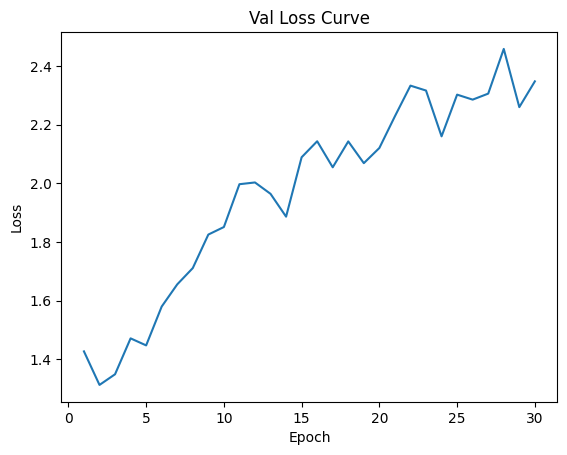

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 0


In [25]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # Replace the last fully connected layer with a new one
    teacher_model.classifier = nn.Linear(1536, num_classes)
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=best_lr_teacher)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_teacher)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, 30, i, patience=patience_teacher)

    # Save the teacher model and its state
    torch.save(teacher_model.state_dict(), f'teacher_model_weights_rkd_wider_lambda{i}2.pth')
    torch.save(teacher_model, f'teacher_model_rkd_wider_lambda{i}2.pth')
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:59<00:00,  1.36it/s]


*******Epoch 0: loss - 1.0134451731487557


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.37it/s]


*******Epoch 1: loss - 0.7779919214454698


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.36it/s]


*******Epoch 2: loss - 0.6538011955994146


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:04<00:00,  1.30it/s]


Average Pretrain Adversary epoch loss:  0.498675341407458


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:02<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.49686555141284144


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:03<00:00,  1.31it/s]


Average Pretrain Adversary epoch loss:  0.4993385128033014


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:51<00:00,  1.45it/s]


Average Adversary epoch loss: 0.3395042103933699


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 1/20*****
*****Train Loss:  3.360212 Val Loss:  3.157307*****
*****Validation Accuracy: 55.06%*****
*****Total Avg Disparity: 0.15236797692379847*****

Class Team_Sports: Recall Difference = 0.1548862659973771
Class Celebration: Recall Difference = -0.013440860215053752
Class Parade: Recall Difference = -0.0070608460735555045
Class Waiter_Or_Waitress: Recall Difference = -0.33516483516483525
Class Individual_Sports: Recall Difference = -0.1320747520976353
Class Surgeons: Recall Difference = 0.17113095238095238
Class Spa: Recall Difference = -0.32653061224489793
Class Law_Enforcement: Recall Difference = 0.057637600494743424
Class Business: Recall Difference = 0.051658163265306145
Class Dresses: Recall Difference = -0.5980769230769232
Class Water Activities: Recall Difference = -0.012759170653907415
Class Picnic: Recall Difference = -0.4
Class Rescue: Recall Difference = 0.05294705294705293
Class Cheering: Recall Difference = -0.004716981132075443
Class Performance_And_Entert

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:53<00:00,  1.43it/s]


Average Adversary epoch loss: 0.22828271589529367


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 2/20*****
*****Train Loss:  2.892195 Val Loss:  3.046444*****
*****Validation Accuracy: 57.72%*****
*****Total Avg Disparity: 0.17548765846495434*****

Class Team_Sports: Recall Difference = 0.07721702166146616
Class Celebration: Recall Difference = 0.08141321044546856
Class Parade: Recall Difference = -0.06575796647633081
Class Waiter_Or_Waitress: Recall Difference = -0.16797488226059654
Class Individual_Sports: Recall Difference = -0.14218154080854328
Class Surgeons: Recall Difference = -0.008928571428571452
Class Spa: Recall Difference = -0.7551020408163265
Class Law_Enforcement: Recall Difference = 0.06679035250463816
Class Business: Recall Difference = 0.06271258503401356
Class Dresses: Recall Difference = -0.6562500000000001
Class Water Activities: Recall Difference = 0.09284575074048751
Class Picnic: Recall Difference = -0.49090909090909096
Class Rescue: Recall Difference = 0.015984015984015998
Class Cheering: Recall Difference = -0.05537325676784244
Class Performance

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:53<00:00,  1.43it/s]


Average Adversary epoch loss: 0.1914988255335225


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 3/20*****
*****Train Loss:  2.621569 Val Loss:  3.276925*****
*****Validation Accuracy: 58.41%*****
*****Total Avg Disparity: 0.19852888239110533*****

Class Team_Sports: Recall Difference = 0.1102518880296659
Class Celebration: Recall Difference = -0.09984639016897084
Class Parade: Recall Difference = -0.07140664333517521
Class Waiter_Or_Waitress: Recall Difference = -0.11930926216640514
Class Individual_Sports: Recall Difference = -0.11590389016018299
Class Surgeons: Recall Difference = -0.20684523809523808
Class Spa: Recall Difference = -0.7755102040816326
Class Law_Enforcement: Recall Difference = 0.0644403215831787
Class Business: Recall Difference = 0.08184523809523814
Class Dresses: Recall Difference = -0.5918269230769231
Class Water Activities: Recall Difference = 0.09239006607427669
Class Picnic: Recall Difference = -0.5454545454545454
Class Rescue: Recall Difference = 0.1318681318681319
Class Cheering: Recall Difference = -0.06706316652994254
Class Performance_And_

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.17345860140559113


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 4/20*****
*****Train Loss:  2.412491 Val Loss:  3.205576*****
*****Validation Accuracy: 58.44%*****
*****Total Avg Disparity: 0.15891081797089107*****

Class Team_Sports: Recall Difference = 0.04011215122326239
Class Celebration: Recall Difference = 0.04608294930875573
Class Parade: Recall Difference = 0.04052311659605817
Class Waiter_Or_Waitress: Recall Difference = -0.25824175824175827
Class Individual_Sports: Recall Difference = -0.09374523264683432
Class Surgeons: Recall Difference = -0.1889880952380953
Class Spa: Recall Difference = 0.22448979591836726
Class Law_Enforcement: Recall Difference = 0.048484848484848464
Class Business: Recall Difference = 0.028911564625850317
Class Dresses: Recall Difference = -0.6004807692307693
Class Water Activities: Recall Difference = 0.039758487126908215
Class Picnic: Recall Difference = -0.5454545454545454
Class Rescue: Recall Difference = -0.0844155844155845
Class Cheering: Recall Difference = -0.050246103363412675
Class Performance_

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.17142003461902525


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 5/20*****
*****Train Loss:  2.201594 Val Loss:  3.212762*****
*****Validation Accuracy: 60.32%*****
*****Total Avg Disparity: 0.14563125802456173*****

Class Team_Sports: Recall Difference = 0.09641387419165204
Class Celebration: Recall Difference = 0.014208909370199696
Class Parade: Recall Difference = -0.07779210413212989
Class Waiter_Or_Waitress: Recall Difference = -0.0808477237048667
Class Individual_Sports: Recall Difference = -0.11308161708619369
Class Surgeons: Recall Difference = 0.03125
Class Spa: Recall Difference = -0.44897959183673464
Class Law_Enforcement: Recall Difference = 0.08484848484848484
Class Business: Recall Difference = -0.08269557823129253
Class Dresses: Recall Difference = -0.5567307692307693
Class Water Activities: Recall Difference = 0.025062656641603898
Class Picnic: Recall Difference = -0.43636363636363634
Class Rescue: Recall Difference = 0.054445554445554434
Class Cheering: Recall Difference = -0.10254306808859728
Class Performance_And_Entert

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:51<00:00,  1.45it/s]


Average Adversary epoch loss: 0.16877861652109358


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 6/20*****
*****Train Loss:  2.098811 Val Loss:  3.236757*****
*****Validation Accuracy: 60.69%*****
*****Total Avg Disparity: 0.12532892742720725*****

Class Team_Sports: Recall Difference = 0.0340071451182562
Class Celebration: Recall Difference = 0.016513056835637474
Class Parade: Recall Difference = -0.052311659605820626
Class Waiter_Or_Waitress: Recall Difference = -0.1938775510204082
Class Individual_Sports: Recall Difference = -0.09065598779557604
Class Surgeons: Recall Difference = -0.09374999999999989
Class Spa: Recall Difference = 0.26530612244897966
Class Law_Enforcement: Recall Difference = 0.059987631416203
Class Business: Recall Difference = -0.060799319727891155
Class Dresses: Recall Difference = -0.4235576923076924
Class Water Activities: Recall Difference = 0.00991114149008887
Class Picnic: Recall Difference = -0.21818181818181823
Class Rescue: Recall Difference = 0.12662337662337664
Class Cheering: Recall Difference = -0.045118949958982746
Class Performance_

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.16495684056002416


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 7/20*****
*****Train Loss:  1.969162 Val Loss:  3.257072*****
*****Validation Accuracy: 62.11%*****
*****Total Avg Disparity: 0.16590624695907158*****

Class Team_Sports: Recall Difference = 0.1279790168679058
Class Celebration: Recall Difference = 0.013440860215053807
Class Parade: Recall Difference = -0.09301897218640642
Class Waiter_Or_Waitress: Recall Difference = -0.07299843014128726
Class Individual_Sports: Recall Difference = -0.07902364607170109
Class Surgeons: Recall Difference = -0.055059523809523836
Class Spa: Recall Difference = -0.7959183673469388
Class Law_Enforcement: Recall Difference = 0.06666666666666665
Class Business: Recall Difference = -0.060799319727891155
Class Dresses: Recall Difference = -0.5649038461538463
Class Water Activities: Recall Difference = 0.07017543859649134
Class Picnic: Recall Difference = -0.34545454545454546
Class Rescue: Recall Difference = 0.13961038961038966
Class Cheering: Recall Difference = -0.12407711238720265
Class Performanc

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:51<00:00,  1.45it/s]


Average Adversary epoch loss: 0.1588031862988884


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 8/20*****
*****Train Loss:  1.841677 Val Loss:  3.214706*****
*****Validation Accuracy: 61.21%*****
*****Total Avg Disparity: 0.1567226444239397*****

Class Team_Sports: Recall Difference = 0.06760728982951192
Class Celebration: Recall Difference = 0.010368663594469973
Class Parade: Recall Difference = -0.0960275066003562
Class Waiter_Or_Waitress: Recall Difference = -0.1020408163265305
Class Individual_Sports: Recall Difference = -0.11376811594202885
Class Surgeons: Recall Difference = -0.016369047619047616
Class Spa: Recall Difference = -0.6326530612244898
Class Law_Enforcement: Recall Difference = 0.17118119975262835
Class Business: Recall Difference = 0.08184523809523808
Class Dresses: Recall Difference = -0.5442307692307692
Class Water Activities: Recall Difference = 0.07780815675552522
Class Picnic: Recall Difference = -0.4
Class Rescue: Recall Difference = 0.06843156843156845
Class Cheering: Recall Difference = -0.005947497949138569
Class Performance_And_Entertainment

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.15624661674654042


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 9/20*****
*****Train Loss:  1.743064 Val Loss:  3.321146*****
*****Validation Accuracy: 61.04%*****
*****Total Avg Disparity: 0.13415874308274928*****

Class Team_Sports: Recall Difference = 0.03527336860670205
Class Celebration: Recall Difference = 0.013056835637480724
Class Parade: Recall Difference = -0.06870510222877146
Class Waiter_Or_Waitress: Recall Difference = -0.05259026687598123
Class Individual_Sports: Recall Difference = -0.032379862700228745
Class Surgeons: Recall Difference = -0.16369047619047628
Class Spa: Recall Difference = -0.4693877551020408
Class Law_Enforcement: Recall Difference = -0.0035868893011751224
Class Business: Recall Difference = -0.04166666666666663
Class Dresses: Recall Difference = -0.5442307692307692
Class Water Activities: Recall Difference = 0.108794714057872
Class Picnic: Recall Difference = -0.32727272727272727
Class Rescue: Recall Difference = 0.04245754245754246
Class Cheering: Recall Difference = -0.03650533223954061
Class Performan

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.1563028692279333


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 10/20*****
*****Train Loss:  1.692238 Val Loss:  3.305475*****
*****Validation Accuracy: 61.93%*****
*****Total Avg Disparity: 0.18158916868655212*****

Class Team_Sports: Recall Difference = 0.09842626509293173
Class Celebration: Recall Difference = -0.06067588325652845
Class Parade: Recall Difference = -0.09148400564867698
Class Waiter_Or_Waitress: Recall Difference = -0.02982731554160145
Class Individual_Sports: Recall Difference = -0.0488939740655987
Class Surgeons: Recall Difference = -0.1562500000000001
Class Spa: Recall Difference = -0.6326530612244898
Class Law_Enforcement: Recall Difference = 0.04415584415584417
Class Business: Recall Difference = -0.07355442176870752
Class Dresses: Recall Difference = -0.6004807692307693
Class Water Activities: Recall Difference = 0.01788562314878106
Class Picnic: Recall Difference = -0.490909090909091
Class Rescue: Recall Difference = 0.09540459540459545
Class Cheering: Recall Difference = -0.09228876127973756
Class Performance_An

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:53<00:00,  1.43it/s]


Average Adversary epoch loss: 0.15588615163240904


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 11/20*****
*****Train Loss:  1.633373 Val Loss:  3.355870*****
*****Validation Accuracy: 61.73%*****
*****Total Avg Disparity: 0.17634198139448293*****

Class Team_Sports: Recall Difference = 0.0806539139872473
Class Celebration: Recall Difference = 0.011904761904761862
Class Parade: Recall Difference = -0.05808313378768337
Class Waiter_Or_Waitress: Recall Difference = -0.09105180533751978
Class Individual_Sports: Recall Difference = -0.1169336384439359
Class Surgeons: Recall Difference = -0.08630952380952384
Class Spa: Recall Difference = -0.673469387755102
Class Law_Enforcement: Recall Difference = 0.1210884353741496
Class Business: Recall Difference = -0.020408163265306256
Class Dresses: Recall Difference = -0.6355769230769233
Class Water Activities: Recall Difference = 0.01788562314878106
Class Picnic: Recall Difference = -0.2727272727272728
Class Rescue: Recall Difference = 0.13961038961038957
Class Cheering: Recall Difference = -0.0791632485643971
Class Performance_And

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:50<00:00,  1.46it/s]


Average Adversary epoch loss: 0.15649445888436872


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 12/20*****
*****Train Loss:  1.557085 Val Loss:  3.433450*****
*****Validation Accuracy: 61.53%*****
*****Total Avg Disparity: 0.18800726854672445*****

Class Team_Sports: Recall Difference = 0.08605797494686374
Class Celebration: Recall Difference = -0.02956989247311831
Class Parade: Recall Difference = -0.09725547983053973
Class Waiter_Or_Waitress: Recall Difference = -0.1781789638932496
Class Individual_Sports: Recall Difference = -0.039054157131960254
Class Surgeons: Recall Difference = -0.16517857142857145
Class Spa: Recall Difference = -0.7551020408163266
Class Law_Enforcement: Recall Difference = 0.14619666048237479
Class Business: Recall Difference = -0.04102891156462585
Class Dresses: Recall Difference = -0.5961538461538461
Class Water Activities: Recall Difference = 0.04761904761904767
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = 0.1838161838161838
Class Cheering: Recall Difference = -0.1714520098441345
Class Performance_

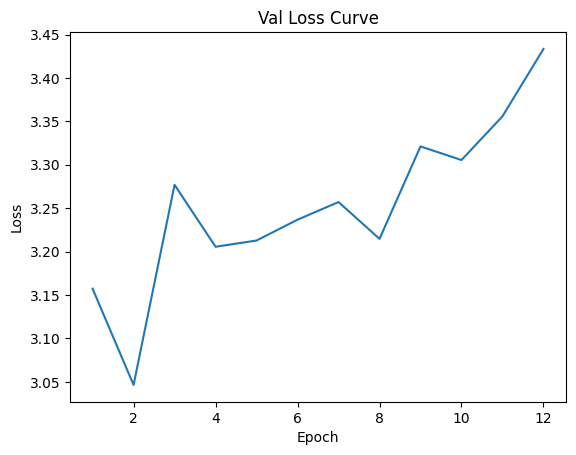

Student weights and architecture saved and exported for lambda: 0


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.36it/s]


*******Epoch 0: loss - 1.0188390520619757


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.37it/s]


*******Epoch 1: loss - 0.7742211958508433


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.37it/s]


*******Epoch 2: loss - 0.6681482374300192


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:03<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.39809305248437105


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:02<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.39952568305127417


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:04<00:00,  1.30it/s]


Average Pretrain Adversary epoch loss:  0.3965505141718888


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.2810888573711301


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 1/20*****
*****Train Loss:  18.516424 Val Loss:  20.444685*****
*****Validation Accuracy: 50.27%*****
*****Total Avg Disparity: 0.1792776266859381*****

Class Team_Sports: Recall Difference = 0.08427169538280654
Class Celebration: Recall Difference = 0.009216589861751168
Class Parade: Recall Difference = -0.09909743967581508
Class Waiter_Or_Waitress: Recall Difference = -0.270800627943485
Class Individual_Sports: Recall Difference = -0.11830663615560655
Class Surgeons: Recall Difference = -0.22321428571428573
Class Spa: Recall Difference = -0.673469387755102
Class Law_Enforcement: Recall Difference = 0.1736549165120594
Class Business: Recall Difference = 0.012967687074829926
Class Dresses: Recall Difference = -0.6875
Class Water Activities: Recall Difference = 0.03315105946684893
Class Picnic: Recall Difference = -0.32727272727272727
Class Rescue: Recall Difference = 0.006743256743256744
Class Cheering: Recall Difference = -0.015586546349466768
Class Performance_And_Entertai

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:51<00:00,  1.45it/s]


Average Adversary epoch loss: 0.21362649382632456


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.75it/s]


*****Epoch 2/20*****
*****Train Loss:  19.270765 Val Loss:  20.938483*****
*****Validation Accuracy: 55.70%*****
*****Total Avg Disparity: 0.14946173242594013*****

Class Team_Sports: Recall Difference = 0.10331026997693649
Class Celebration: Recall Difference = -0.023425499231950864
Class Parade: Recall Difference = -0.12402529624854186
Class Waiter_Or_Waitress: Recall Difference = -0.12480376766091061
Class Individual_Sports: Recall Difference = -0.13089244851258586
Class Surgeons: Recall Difference = -0.035714285714285726
Class Spa: Recall Difference = 0.4897959183673469
Class Law_Enforcement: Recall Difference = 0.17612863327149042
Class Business: Recall Difference = 0.07504251700680276
Class Dresses: Recall Difference = -0.6543269230769231
Class Water Activities: Recall Difference = 0.02540442014126243
Class Picnic: Recall Difference = -0.14545454545454548
Class Rescue: Recall Difference = 0.06743256743256745
Class Cheering: Recall Difference = -0.040196882690730074
Class Performa

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.19459686474299726


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 3/20*****
*****Train Loss:  17.980570 Val Loss:  19.652202*****
*****Validation Accuracy: 57.46%*****
*****Total Avg Disparity: 0.17366228389364088*****

Class Team_Sports: Recall Difference = 0.06355989689323016
Class Celebration: Recall Difference = -0.019969278033794113
Class Parade: Recall Difference = -0.1258058574323081
Class Waiter_Or_Waitress: Recall Difference = -0.1703296703296704
Class Individual_Sports: Recall Difference = -0.021777269260106702
Class Surgeons: Recall Difference = -0.0788690476190475
Class Spa: Recall Difference = 0.4285714285714286
Class Law_Enforcement: Recall Difference = 0.17798392084106385
Class Business: Recall Difference = -0.03698979591836732
Class Dresses: Recall Difference = -0.79375
Class Water Activities: Recall Difference = 0.10002278423331068
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = 0.05969030969030967
Class Cheering: Recall Difference = -0.10172272354388845
Class Performance_And_Entert

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.18223467110483735


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 4/20*****
*****Train Loss:  18.298735 Val Loss:  24.291554*****
*****Validation Accuracy: 56.83%*****
*****Total Avg Disparity: 0.1941954863591071*****

Class Team_Sports: Recall Difference = 0.10532266087821651
Class Celebration: Recall Difference = -0.036098310291858615
Class Parade: Recall Difference = -0.047768158654141524
Class Waiter_Or_Waitress: Recall Difference = -0.1475667189952906
Class Individual_Sports: Recall Difference = -0.06346300533943561
Class Surgeons: Recall Difference = -0.13392857142857145
Class Spa: Recall Difference = -0.6122448979591837
Class Law_Enforcement: Recall Difference = 0.05108225108225101
Class Business: Recall Difference = -0.00340136054421758
Class Dresses: Recall Difference = -0.7168269230769232
Class Water Activities: Recall Difference = 0.07142857142857162
Class Picnic: Recall Difference = -0.4
Class Rescue: Recall Difference = 0.21703296703296696
Class Cheering: Recall Difference = -0.1605824446267432
Class Performance_And_Entertainm

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.17545404561139918


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 5/20*****
*****Train Loss:  17.398932 Val Loss:  26.005641*****
*****Validation Accuracy: 58.18%*****
*****Total Avg Disparity: 0.16806558299797203*****

Class Team_Sports: Recall Difference = 0.05926378148600353
Class Celebration: Recall Difference = -0.004224270353302639
Class Parade: Recall Difference = -0.09424694541658996
Class Waiter_Or_Waitress: Recall Difference = -0.09968602825745698
Class Individual_Sports: Recall Difference = -0.18386727688787197
Class Surgeons: Recall Difference = -0.1264880952380953
Class Spa: Recall Difference = -0.5102040816326531
Class Law_Enforcement: Recall Difference = 0.11886209029066175
Class Business: Recall Difference = -0.04889455782312924
Class Dresses: Recall Difference = -0.635576923076923
Class Water Activities: Recall Difference = 0.03315105946684893
Class Picnic: Recall Difference = -0.20000000000000004
Class Rescue: Recall Difference = 0.07417582417582419
Class Cheering: Recall Difference = -0.11792452830188677
Class Performanc

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:53<00:00,  1.43it/s]


Average Adversary epoch loss: 0.1712402873845012


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 6/20*****
*****Train Loss:  16.734370 Val Loss:  25.794392*****
*****Validation Accuracy: 58.90%*****
*****Total Avg Disparity: 0.14151336353974525*****

Class Team_Sports: Recall Difference = 0.09030886808664595
Class Celebration: Recall Difference = 0.028801843317972364
Class Parade: Recall Difference = -0.09179099895622256
Class Waiter_Or_Waitress: Recall Difference = -0.0808477237048667
Class Individual_Sports: Recall Difference = -0.04923722349351645
Class Surgeons: Recall Difference = -0.047619047619047616
Class Spa: Recall Difference = -0.6122448979591837
Class Law_Enforcement: Recall Difference = 0.007792207792207795
Class Business: Recall Difference = 0.0607993197278911
Class Dresses: Recall Difference = -0.5149038461538461
Class Water Activities: Recall Difference = -0.027341079972658777
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = 0.06743256743256748
Class Cheering: Recall Difference = -0.07280557834290402
Class Performa

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:53<00:00,  1.43it/s]


Average Adversary epoch loss: 0.1730839843735283


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 7/20*****
*****Train Loss:  14.548096 Val Loss:  26.574626*****
*****Validation Accuracy: 59.34%*****
*****Total Avg Disparity: 0.154435308381498*****

Class Team_Sports: Recall Difference = 0.07999819110930229
Class Celebration: Recall Difference = 0.04377880184331795
Class Parade: Recall Difference = -0.08239700374531844
Class Waiter_Or_Waitress: Recall Difference = 0.049450549450549386
Class Individual_Sports: Recall Difference = -0.09836003051106024
Class Surgeons: Recall Difference = -0.017857142857142905
Class Spa: Recall Difference = -0.6938775510204082
Class Law_Enforcement: Recall Difference = 0.1053803339517625
Class Business: Recall Difference = -0.00914115646258501
Class Dresses: Recall Difference = -0.6793269230769232
Class Water Activities: Recall Difference = 0.07063112326270227
Class Picnic: Recall Difference = -0.2545454545454545
Class Rescue: Recall Difference = 0.036213786213786237
Class Cheering: Recall Difference = -0.024200164068908903
Class Performance

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:53<00:00,  1.43it/s]


Average Adversary epoch loss: 0.17040076382734157


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 8/20*****
*****Train Loss:  13.923274 Val Loss:  26.606910*****
*****Validation Accuracy: 59.22%*****
*****Total Avg Disparity: 0.18651923496314055*****

Class Team_Sports: Recall Difference = 0.07723963279518842
Class Celebration: Recall Difference = -0.07066052227342545
Class Parade: Recall Difference = -0.05145207834469212
Class Waiter_Or_Waitress: Recall Difference = -0.0808477237048667
Class Individual_Sports: Recall Difference = -0.1491990846681922
Class Surgeons: Recall Difference = -0.09375
Class Spa: Recall Difference = -0.7755102040816326
Class Law_Enforcement: Recall Difference = 0.09424860853432282
Class Business: Recall Difference = 0.009353741496598733
Class Dresses: Recall Difference = -0.7125
Class Water Activities: Recall Difference = 0.04750512645249505
Class Picnic: Recall Difference = -0.36363636363636376
Class Rescue: Recall Difference = 0.2435064935064935
Class Cheering: Recall Difference = 0.004922067268252672
Class Performance_And_Entertainment: Recal

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:53<00:00,  1.43it/s]


Average Adversary epoch loss: 0.16579507309713482


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 9/20*****
*****Train Loss:  14.463454 Val Loss:  29.710987*****
*****Validation Accuracy: 58.50%*****
*****Total Avg Disparity: 0.1702092773720745*****

Class Team_Sports: Recall Difference = 0.0964364853253743
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = -0.048689138576779145
Class Waiter_Or_Waitress: Recall Difference = -0.10204081632653067
Class Individual_Sports: Recall Difference = -0.13729977116704817
Class Surgeons: Recall Difference = -0.04017857142857145
Class Spa: Recall Difference = -0.5102040816326531
Class Law_Enforcement: Recall Difference = 0.13729128014842307
Class Business: Recall Difference = -0.07057823129251695
Class Dresses: Recall Difference = -0.691826923076923
Class Water Activities: Recall Difference = 0.07074504442925511
Class Picnic: Recall Difference = -0.34545454545454546
Class Rescue: Recall Difference = 0.13286713286713292
Class Cheering: Recall Difference = -0.07116488925348641
Class Performance_And_Entertainmen

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:54<00:00,  1.42it/s]


Average Adversary epoch loss: 0.16070908547183613


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 10/20*****
*****Train Loss:  13.391507 Val Loss:  29.710869*****
*****Validation Accuracy: 60.12%*****
*****Total Avg Disparity: 0.15087286007146186*****

Class Team_Sports: Recall Difference = 0.03744403744403746
Class Celebration: Recall Difference = -0.05645161290322587
Class Parade: Recall Difference = 0.006569656781482247
Class Waiter_Or_Waitress: Recall Difference = -0.10910518053375196
Class Individual_Sports: Recall Difference = -0.07517162471395888
Class Surgeons: Recall Difference = 0.10119047619047616
Class Spa: Recall Difference = -0.6326530612244898
Class Law_Enforcement: Recall Difference = 0.03475572047000619
Class Business: Recall Difference = 0.030612244897959273
Class Dresses: Recall Difference = -0.616826923076923
Class Water Activities: Recall Difference = -0.012759170653907415
Class Picnic: Recall Difference = -0.2727272727272727
Class Rescue: Recall Difference = 0.05594405594405599
Class Cheering: Recall Difference = -0.08285479901558662
Class Performan

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.15999597099460203


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 11/20*****
*****Train Loss:  12.918089 Val Loss:  29.277737*****
*****Validation Accuracy: 60.03%*****
*****Total Avg Disparity: 0.16325826389312112*****

Class Team_Sports: Recall Difference = 0.07868674535341202
Class Celebration: Recall Difference = -0.017281105990783363
Class Parade: Recall Difference = -0.01891078774482713
Class Waiter_Or_Waitress: Recall Difference = -0.11459968602825743
Class Individual_Sports: Recall Difference = -0.09553775743707105
Class Surgeons: Recall Difference = -0.1741071428571429
Class Spa: Recall Difference = -0.6122448979591837
Class Law_Enforcement: Recall Difference = 0.06221397649969085
Class Business: Recall Difference = -0.02274659863945583
Class Dresses: Recall Difference = -0.7375
Class Water Activities: Recall Difference = 0.0930735930735932
Class Picnic: Recall Difference = -0.3090909090909092
Class Rescue: Recall Difference = 0.10014985014985014
Class Cheering: Recall Difference = -0.13146021328958163
Class Performance_And_Entert

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:51<00:00,  1.46it/s]


Average Adversary epoch loss: 0.16106684202397312


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 12/20*****
*****Train Loss:  12.756639 Val Loss:  31.268520*****
*****Validation Accuracy: 60.20%*****
*****Total Avg Disparity: 0.14001266335709098*****

Class Team_Sports: Recall Difference = 0.0641025641025641
Class Celebration: Recall Difference = 0.04301075268817206
Class Parade: Recall Difference = -0.15104070731258057
Class Waiter_Or_Waitress: Recall Difference = 0.01098901098901095
Class Individual_Sports: Recall Difference = -0.17402745995423347
Class Surgeons: Recall Difference = -0.047619047619047616
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.09387755102040818
Class Business: Recall Difference = 0.07206632653061229
Class Dresses: Recall Difference = -0.6086538461538461
Class Water Activities: Recall Difference = 0.07792207792207806
Class Picnic: Recall Difference = -0.3090909090909091
Class Rescue: Recall Difference = 0.04045954045954045
Class Cheering: Recall Difference = -0.16776045939294504
Class Performance_A

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:51<00:00,  1.45it/s]


Average Adversary epoch loss: 0.15885823026851373


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 13/20*****
*****Train Loss:  12.206162 Val Loss:  31.984726*****
*****Validation Accuracy: 60.69%*****
*****Total Avg Disparity: 0.15062332992007627*****

Class Team_Sports: Recall Difference = 0.05107855107855108
Class Celebration: Recall Difference = -0.025345622119815725
Class Parade: Recall Difference = -0.06931908884386317
Class Waiter_Or_Waitress: Recall Difference = 0.0007849293563578774
Class Individual_Sports: Recall Difference = -0.13550724637681144
Class Surgeons: Recall Difference = 0.022321428571428548
Class Spa: Recall Difference = -0.7755102040816326
Class Law_Enforcement: Recall Difference = 0.07124304267161408
Class Business: Recall Difference = -0.01041666666666663
Class Dresses: Recall Difference = -0.6230769230769231
Class Water Activities: Recall Difference = 0.01754385964912286
Class Picnic: Recall Difference = -0.34545454545454546
Class Rescue: Recall Difference = 0.042957042957042946
Class Cheering: Recall Difference = -0.08223954060705496
Class Perfo

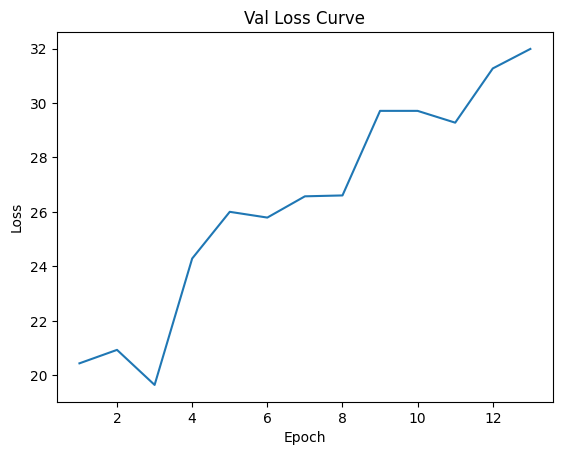

Student weights and architecture saved and exported for lambda: 3


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.37it/s]


*******Epoch 0: loss - 1.025458037485311


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:00<00:00,  1.35it/s]


*******Epoch 1: loss - 0.7813252600622765


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:00<00:00,  1.35it/s]


*******Epoch 2: loss - 0.6655657000747728


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:05<00:00,  1.29it/s]


Average Pretrain Adversary epoch loss:  0.4290718158454071


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:03<00:00,  1.31it/s]


Average Pretrain Adversary epoch loss:  0.42858004404438865


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:05<00:00,  1.29it/s]


Average Pretrain Adversary epoch loss:  0.4261533189334987


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.32748027946110125


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 1/20*****
*****Train Loss:  16.703658 Val Loss:  23.217398*****
*****Validation Accuracy: 51.08%*****
*****Total Avg Disparity: 0.17236234994863275*****

Class Team_Sports: Recall Difference = 0.06627323293989962
Class Celebration: Recall Difference = -0.09677419354838712
Class Parade: Recall Difference = -0.11426290906858239
Class Waiter_Or_Waitress: Recall Difference = -0.34850863422292
Class Individual_Sports: Recall Difference = -0.17231121281464534
Class Surgeons: Recall Difference = 0.0892857142857143
Class Spa: Recall Difference = -0.4489795918367347
Class Law_Enforcement: Recall Difference = 0.15794681508967223
Class Business: Recall Difference = -0.004676870748299283
Class Dresses: Recall Difference = -0.49182692307692294
Class Water Activities: Recall Difference = -0.011619958988379975
Class Picnic: Recall Difference = -0.3090909090909091
Class Rescue: Recall Difference = 0.04045954045954048
Class Cheering: Recall Difference = 0.0625512715340443
Class Performance_A

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:53<00:00,  1.43it/s]


Average Adversary epoch loss: 0.20356267359521654


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 2/20*****
*****Train Loss:  18.456461 Val Loss:  20.249915*****
*****Validation Accuracy: 54.75%*****
*****Total Avg Disparity: 0.1490307400424532*****

Class Team_Sports: Recall Difference = 0.1150002261113372
Class Celebration: Recall Difference = -0.004992319508448584
Class Parade: Recall Difference = -0.007122244735064842
Class Waiter_Or_Waitress: Recall Difference = -0.1656200941915229
Class Individual_Sports: Recall Difference = -0.17444698703279926
Class Surgeons: Recall Difference = 0.0758928571428571
Class Spa: Recall Difference = 0.36734693877551017
Class Law_Enforcement: Recall Difference = 0.11923314780457633
Class Business: Recall Difference = -0.009353741496598567
Class Dresses: Recall Difference = -0.666826923076923
Class Water Activities: Recall Difference = 0.139211665527455
Class Picnic: Recall Difference = -0.1272727272727273
Class Rescue: Recall Difference = 0.09290709290709293
Class Cheering: Recall Difference = 0.029327317473338832
Class Performance_And

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:54<00:00,  1.42it/s]


Average Adversary epoch loss: 0.17454527838178624


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 3/20*****
*****Train Loss:  20.170013 Val Loss:  23.654799*****
*****Validation Accuracy: 56.74%*****
*****Total Avg Disparity: 0.16677354874325775*****

Class Team_Sports: Recall Difference = 0.08074435852213613
Class Celebration: Recall Difference = -0.025345622119815725
Class Parade: Recall Difference = -0.03653220359796161
Class Waiter_Or_Waitress: Recall Difference = -0.15541601255886972
Class Individual_Sports: Recall Difference = -0.1642639206712434
Class Surgeons: Recall Difference = -0.08779761904761907
Class Spa: Recall Difference = -0.5102040816326531
Class Law_Enforcement: Recall Difference = 0.11440940012368583
Class Business: Recall Difference = 0.06377551020408168
Class Dresses: Recall Difference = -0.5649038461538461
Class Water Activities: Recall Difference = 0.07814992025518352
Class Picnic: Recall Difference = -0.4727272727272727
Class Rescue: Recall Difference = 0.08141858141858144
Class Cheering: Recall Difference = 0.0844954881050041
Class Performance_A

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.16440770669299878


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 4/20*****
*****Train Loss:  19.136699 Val Loss:  23.733500*****
*****Validation Accuracy: 56.83%*****
*****Total Avg Disparity: 0.1739902815620488*****

Class Team_Sports: Recall Difference = 0.09650431872654097
Class Celebration: Recall Difference = -0.03725038402457759
Class Parade: Recall Difference = -0.10302695401240247
Class Waiter_Or_Waitress: Recall Difference = -0.18602825745682905
Class Individual_Sports: Recall Difference = -0.1670861937452326
Class Surgeons: Recall Difference = 0.05357142857142855
Class Spa: Recall Difference = -0.5510204081632654
Class Law_Enforcement: Recall Difference = 0.05998763141620289
Class Business: Recall Difference = 0.001913265306122347
Class Dresses: Recall Difference = -0.65625
Class Water Activities: Recall Difference = 0.1307814992025519
Class Picnic: Recall Difference = -0.4
Class Rescue: Recall Difference = -0.029220779220779203
Class Cheering: Recall Difference = -0.035684987694831805
Class Performance_And_Entertainment: Recall

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:53<00:00,  1.42it/s]


Average Adversary epoch loss: 0.16140487964874434


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 5/20*****
*****Train Loss:  17.920746 Val Loss:  26.384485*****
*****Validation Accuracy: 58.33%*****
*****Total Avg Disparity: 0.15192037310855194*****

Class Team_Sports: Recall Difference = 0.05390494279383162
Class Celebration: Recall Difference = 0.004608294930875612
Class Parade: Recall Difference = -0.022901700742923747
Class Waiter_Or_Waitress: Recall Difference = -0.08084772370486659
Class Individual_Sports: Recall Difference = -0.17307398932112894
Class Surgeons: Recall Difference = -0.049107142857142905
Class Spa: Recall Difference = -0.5102040816326531
Class Law_Enforcement: Recall Difference = 0.17130488559059975
Class Business: Recall Difference = 0.008928571428571286
Class Dresses: Recall Difference = -0.63125
Class Water Activities: Recall Difference = 0.07063112326270216
Class Picnic: Recall Difference = -0.2909090909090909
Class Rescue: Recall Difference = 0.13136863136863142
Class Cheering: Recall Difference = 0.03465955701394585
Class Performance_And_Ente

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.1620253248623124


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 6/20*****
*****Train Loss:  16.734820 Val Loss:  25.934331*****
*****Validation Accuracy: 58.76%*****
*****Total Avg Disparity: 0.15728955589988525*****

Class Team_Sports: Recall Difference = 0.059354226020892686
Class Celebration: Recall Difference = 0.028033794162826364
Class Parade: Recall Difference = 0.006262663473936225
Class Waiter_Or_Waitress: Recall Difference = -0.13736263736263732
Class Individual_Sports: Recall Difference = -0.09271548436308163
Class Surgeons: Recall Difference = -0.19940476190476192
Class Spa: Recall Difference = 0.326530612244898
Class Law_Enforcement: Recall Difference = 0.09412492269635125
Class Business: Recall Difference = 0.011267006802721191
Class Dresses: Recall Difference = -0.75
Class Water Activities: Recall Difference = 0.12326270221007052
Class Picnic: Recall Difference = -0.45454545454545453
Class Rescue: Recall Difference = 0.09390609390609392
Class Cheering: Recall Difference = -0.047374897456931964
Class Performance_And_Enterta

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:53<00:00,  1.42it/s]


Average Adversary epoch loss: 0.15984692958034116


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 7/20*****
*****Train Loss:  15.899711 Val Loss:  25.495434*****
*****Validation Accuracy: 60.89%*****
*****Total Avg Disparity: 0.16784255403215453*****

Class Team_Sports: Recall Difference = 0.11086238864016651
Class Celebration: Recall Difference = -0.011520737327188946
Class Parade: Recall Difference = -0.03683919690550752
Class Waiter_Or_Waitress: Recall Difference = -0.18602825745682905
Class Individual_Sports: Recall Difference = -0.22246376811594204
Class Surgeons: Recall Difference = -0.11755952380952384
Class Spa: Recall Difference = 0.30612244897959184
Class Law_Enforcement: Recall Difference = 0.05306122448979589
Class Business: Recall Difference = -0.10437925170068019
Class Dresses: Recall Difference = -0.710576923076923
Class Water Activities: Recall Difference = 0.09273182957393489
Class Picnic: Recall Difference = -0.4
Class Rescue: Recall Difference = 0.06118881118881117
Class Cheering: Recall Difference = -0.06480721903199343
Class Performance_And_Entertain

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:54<00:00,  1.42it/s]


Average Adversary epoch loss: 0.15669144979781574


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.71it/s]


*****Epoch 8/20*****
*****Train Loss:  15.062688 Val Loss:  27.270278*****
*****Validation Accuracy: 59.74%*****
*****Total Avg Disparity: 0.15692562866667553*****

Class Team_Sports: Recall Difference = 0.08612580834803063
Class Celebration: Recall Difference = 0.11405529953917048
Class Parade: Recall Difference = -0.024682261926690208
Class Waiter_Or_Waitress: Recall Difference = -0.16012558869701732
Class Individual_Sports: Recall Difference = -0.1512585812356979
Class Surgeons: Recall Difference = -0.049107142857142905
Class Spa: Recall Difference = 0.4285714285714286
Class Law_Enforcement: Recall Difference = -0.010389610389610393
Class Business: Recall Difference = -0.021258503401360596
Class Dresses: Recall Difference = -0.666826923076923
Class Water Activities: Recall Difference = 0.07006151742993849
Class Picnic: Recall Difference = -0.32727272727272727
Class Rescue: Recall Difference = 0.21703296703296707
Class Cheering: Recall Difference = -0.023584905660377325
Class Perform

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.15862359952779465


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 9/20*****
*****Train Loss:  14.333005 Val Loss:  29.524817*****
*****Validation Accuracy: 60.12%*****
*****Total Avg Disparity: 0.1777464831197333*****

Class Team_Sports: Recall Difference = 0.0702527924750147
Class Celebration: Recall Difference = 0.024577572964669725
Class Parade: Recall Difference = -0.06931908884386317
Class Waiter_Or_Waitress: Recall Difference = -0.1915227629513344
Class Individual_Sports: Recall Difference = -0.12635392829900838
Class Surgeons: Recall Difference = -0.1264880952380953
Class Spa: Recall Difference = -0.5510204081632654
Class Law_Enforcement: Recall Difference = 0.07804576376004946
Class Business: Recall Difference = -0.04102891156462585
Class Dresses: Recall Difference = -0.6086538461538461
Class Water Activities: Recall Difference = -0.005126452494873424
Class Picnic: Recall Difference = -0.4545454545454546
Class Rescue: Recall Difference = 0.08766233766233766
Class Cheering: Recall Difference = -0.10684987694831827
Class Performance_

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:54<00:00,  1.42it/s]


Average Adversary epoch loss: 0.15425910041839988


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 10/20*****
*****Train Loss:  13.494764 Val Loss:  33.229654*****
*****Validation Accuracy: 60.29%*****
*****Total Avg Disparity: 0.12912205654432246*****

Class Team_Sports: Recall Difference = 0.07169990503323831
Class Celebration: Recall Difference = -0.0023041474654377225
Class Parade: Recall Difference = -0.010744765764106323
Class Waiter_Or_Waitress: Recall Difference = -0.10204081632653061
Class Individual_Sports: Recall Difference = -0.13653699466056446
Class Surgeons: Recall Difference = -0.002976190476190521
Class Spa: Recall Difference = 0.30612244897959184
Class Law_Enforcement: Recall Difference = 0.03487940630797781
Class Business: Recall Difference = 0.020408163265306034
Class Dresses: Recall Difference = -0.5793269230769231
Class Water Activities: Recall Difference = 0.024948735475051387
Class Picnic: Recall Difference = -0.38181818181818183
Class Rescue: Recall Difference = 0.1011488511488512
Class Cheering: Recall Difference = -0.0914684167350287
Class Perfo

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:54<00:00,  1.41it/s]


Average Adversary epoch loss: 0.15493829999073053


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.66it/s]


*****Epoch 11/20*****
*****Train Loss:  12.949525 Val Loss:  29.735300*****
*****Validation Accuracy: 59.91%*****
*****Total Avg Disparity: 0.1630155239232787*****

Class Team_Sports: Recall Difference = 0.07174512730068294
Class Celebration: Recall Difference = -0.06451612903225812
Class Parade: Recall Difference = -0.09117701234113096
Class Waiter_Or_Waitress: Recall Difference = -0.10675039246467832
Class Individual_Sports: Recall Difference = -0.07131960335621657
Class Surgeons: Recall Difference = -0.023809523809523836
Class Spa: Recall Difference = -0.5510204081632654
Class Law_Enforcement: Recall Difference = 0.15089672232529378
Class Business: Recall Difference = -0.08014455782312929
Class Dresses: Recall Difference = -0.7043269230769231
Class Water Activities: Recall Difference = 0.04784688995215303
Class Picnic: Recall Difference = -0.20000000000000004
Class Rescue: Recall Difference = 0.18531468531468542
Class Cheering: Recall Difference = -0.07054963084495486
Class Performa

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.36it/s]


Average Adversary epoch loss: 0.15591914841422327


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.64it/s]


*****Epoch 12/20*****
*****Train Loss:  12.634206 Val Loss:  30.342444*****
*****Validation Accuracy: 60.00%*****
*****Total Avg Disparity: 0.15784959593988415*****

Class Team_Sports: Recall Difference = 0.09227603672048112
Class Celebration: Recall Difference = 0.022657450076804864
Class Parade: Recall Difference = 0.06759992632160627
Class Waiter_Or_Waitress: Recall Difference = -0.08869701726844603
Class Individual_Sports: Recall Difference = -0.12711670480549186
Class Surgeons: Recall Difference = -0.06994047619047605
Class Spa: Recall Difference = 0.4897959183673469
Class Law_Enforcement: Recall Difference = 0.11910946196660493
Class Business: Recall Difference = 0.011904761904761973
Class Dresses: Recall Difference = -0.7625
Class Water Activities: Recall Difference = 0.032695374800638
Class Picnic: Recall Difference = -0.34545454545454546
Class Rescue: Recall Difference = 0.09490509490509491
Class Cheering: Recall Difference = -0.06419196062346183
Class Performance_And_Entertai

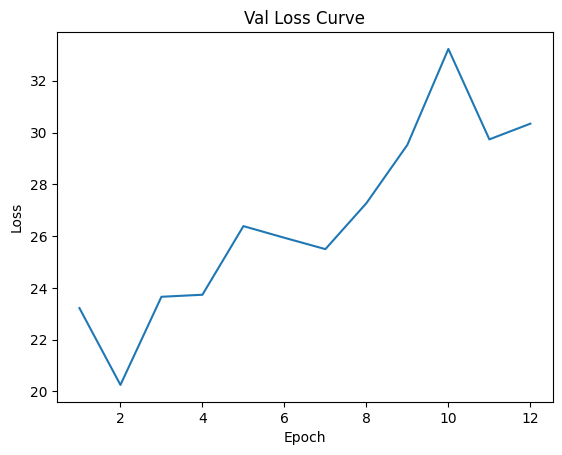

Student weights and architecture saved and exported for lambda: 5


In [54]:
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # load teacher model with lambda 0
    teacher_model = torch.load('teacher_model_rkd_wider_lambda02.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_rkd_wider_lambda02.pth'))
    teacher_model = teacher_model.to(device)
    
    # Reset the student model for each lambda
    student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
    student_model.classifier = nn.Linear(1280, num_classes)
    student_optimizer = optim.Adam(student_model.parameters(), lr=best_lr_student)

    adv = Adversary()
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_student)

    pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
    pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, adv_criterion, student_optimizer, device, alpha, temperature, 20, lmda=i, patience=patience_student, optimizer_adv=student_optimizer_adv)

    torch.save(student_model.state_dict(), f'student_model_weights_rkd_wider_lambda{i}.pth')
    torch.save(student_model, f'student_model_rkd_wider_lambda{i}.pth')
    print('Student weights and architecture saved and exported for lambda:', i)

    # Update the dictionary with the student results
    if i in lambda_results:
        # If the key 'i' is already present in the dictionary
        lambda_results[i].update({
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        })
    else:
        # If the key 'i' is not present in the dictionary
        lambda_results[i] = {
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        }

In [55]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    inputs = inputs.to(device)

    teacher_time, student_time = 0, 0

    if teacher is not None:
        teacher = teacher.to(device)
        start_time = time.time()
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
        teacher_time = time.time() - start_time

    if student is not None:
        student = student.to(device)
        start_time = time.time()
        with torch.no_grad():
            student_outputs = student(inputs)
        student_time = time.time() - start_time
    
    return teacher_time, student_time


In [56]:
# # Loop through each lambda value
# lmda_list = lmda_list_student
# for lmda in lmda_list:
#     # Load teacher and student models for the current lambda
#     # teacher_model = torch.load(f'teacher_model_rkd_wider_lambda{lmda}.pth')
#     # student_model = torch.load(f'student_model_rkd_wider_lambda{lmda}.pth')

#     teacher_model = torch.load(f'teacher_model_rkd_wider_lambda02.pth')
#     student_model = torch.load(f'student_model_rkd_wider_lambda{lmda}.pth')


#     # Compute performance metrics
#     performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

#     # Compute model sizes and inference times
#     teacher_params, student_params = compare_model_size(teacher_model, student_model)
#     teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)

#     # Update results for the current lambda value
#     if lmda in lambda_results:
#         lambda_results[lmda].update({
#             'performance_metrics': performance_metrics,
#             'teacher_params': teacher_params,
#             'student_params': student_params,
#             'teacher_time': teacher_time,
#             'student_time': student_time
#         })
#     else:
#         lambda_results[lmda] = {
#             'performance_metrics': performance_metrics,
#             'teacher_params': teacher_params,
#             'student_params': student_params,
#             'teacher_time': teacher_time,
#             'student_time': student_time
#         }


In [57]:
# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    for lmda_student in lmda_list_student:

        # Load the teacher model for the current lambda from the 'output_dir'
        # teacher_model_path = os.path.join(output_dir, f'teacher_model_rkd_wider_lambda{lmda_teacher}.pth')
        teacher_model_path =f'teacher_model_rkd_wider_lambda02.pth'
        teacher_model = torch.load(teacher_model_path)
        
        # Load the student model for the current lambda from the 'output_dir'
        # student_model_path = os.path.join(output_dir, f'student_model_rkd_wider_lambda{lmda_student}.pth')
        student_model_path = f'student_model_rkd_wider_lambda{lmda_student}.pth'
        student_model = torch.load(student_model_path)
    
        # Compute performance metrics
        performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    
        # Compute model sizes
        teacher_params, student_params = compare_model_size(teacher_model, student_model)
    
        # Construct a unique key for the current combination of lambda values
        lambda_key = (lmda_teacher, lmda_student)

        # Update results for the current lambda value
        if lambda_key in lambda_results:
            lambda_results[lambda_key].update({
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            })
        else:
            lambda_results[lambda_key] = {
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            }


(0, 0, 0) (0.5997113997113998, 0.5997113997113998, 0.5997113997113998)
(0, 3, 5) (0.6152958152958153, 0.606926406926407, 0.6)


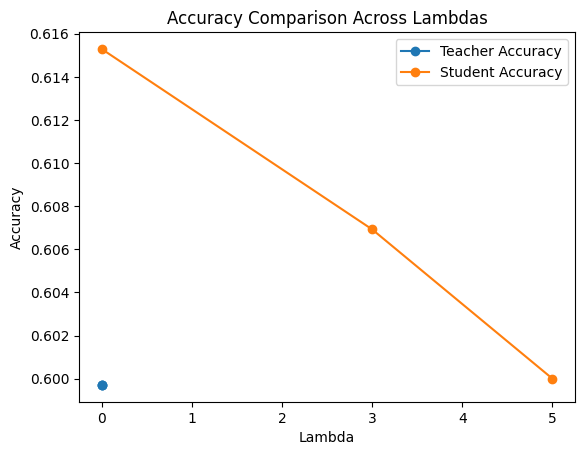

In [58]:
# Initialize lists to store accuracies
teacher_accuracies = []
student_accuracies = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Access the performance metrics for each pair
    teacher_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][0]
    student_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][1]

    # Append accuracies to the lists
    teacher_accuracies.append((lmda_teacher, teacher_accuracy))
    student_accuracies.append((lmda_student, student_accuracy))

# To plot, you might need to separate the lambda values and accuracies
teacher_lambdas, teacher_acc = zip(*teacher_accuracies)
student_lambdas, student_acc = zip(*student_accuracies)

print(teacher_lambdas, teacher_acc)
print(student_lambdas, student_acc)
# Plotting
plt.plot(teacher_lambdas, teacher_acc, label='Teacher Accuracy', marker='o')
plt.plot(student_lambdas, student_acc, label='Student Accuracy', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()
plt.show()


(0, 0, 0) (0.6018209845490271, 0.6018209845490271, 0.6018209845490271)
(0, 3, 5) (0.6170181285889866, 0.604910970531514, 0.6063627586170756)


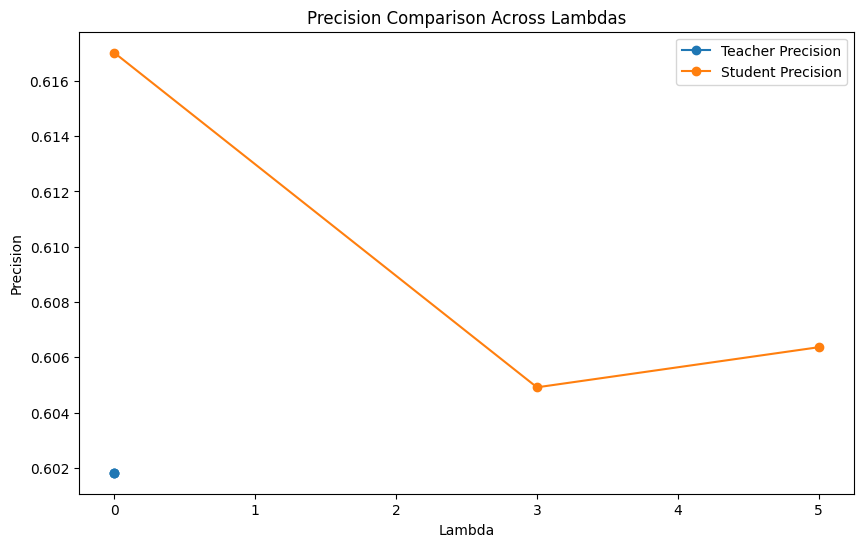

In [59]:
# Initialize lists to store precisions
teacher_precisions = []
student_precisions = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the precision metrics for each pair
        teacher_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][0]
        student_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append precisions to the lists along with lambda values
    teacher_precisions.append((lmda_teacher, teacher_precision))
    student_precisions.append((lmda_student, student_precision))

# To plot, you might need to separate the lambda values and precisions
teacher_lambdas, teacher_prec = zip(*teacher_precisions)
student_lambdas, student_prec = zip(*student_precisions)

print(teacher_lambdas, teacher_prec)
print(student_lambdas, student_prec)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_prec, label='Teacher Precision', marker='o')
plt.plot(student_lambdas, student_prec, label='Student Precision', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()
plt.show()


(0, 0, 0) (0.5997113997113998, 0.5997113997113998, 0.5997113997113998)
(0, 3, 5) (0.6152958152958153, 0.606926406926407, 0.6)


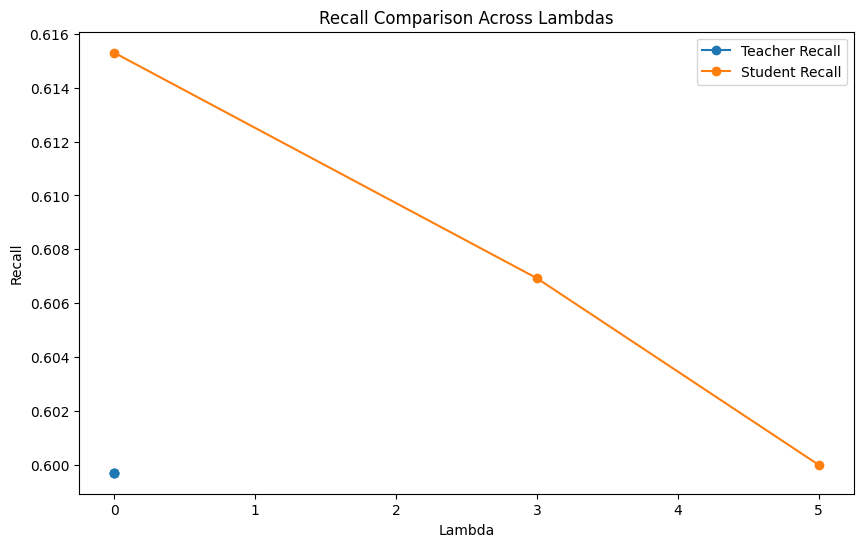

In [60]:
# Initialize lists to store recalls
teacher_recalls = []
student_recalls = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the recall metrics for each pair
        teacher_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][0]
        student_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append recalls to the lists along with lambda values
    teacher_recalls.append((lmda_teacher, teacher_recall))
    student_recalls.append((lmda_student, student_recall))

# To plot, you might need to separate the lambda values and recalls
teacher_lambdas, teacher_rec = zip(*teacher_recalls)
student_lambdas, student_rec = zip(*student_recalls)

print(teacher_lambdas, teacher_rec)
print(student_lambdas, student_rec)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_rec, label='Teacher Recall', marker='o')
plt.plot(student_lambdas, student_rec, label='Student Recall', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()
plt.show()

(0, 0, 0) (0.5947508782046813, 0.5947508782046813, 0.5947508782046813)
(0, 3, 5) (0.6086744120486314, 0.6010119331983803, 0.5959828729771646)


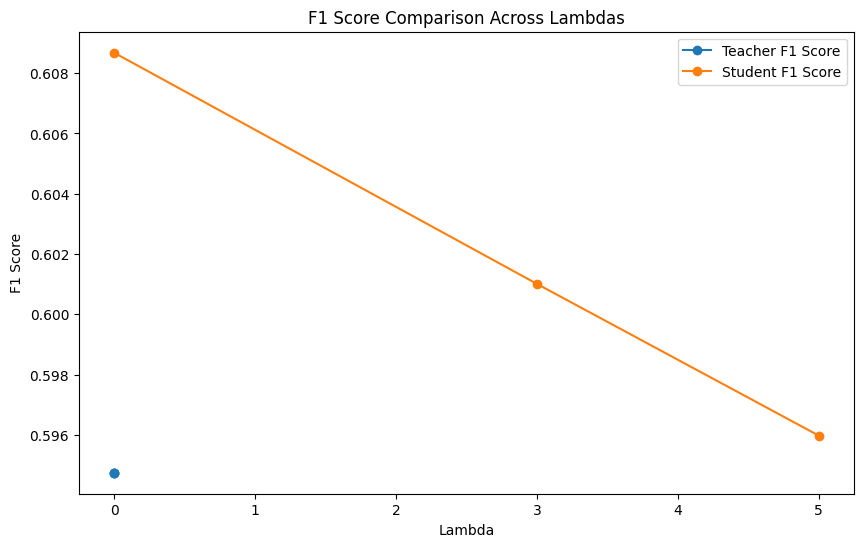

In [61]:
# Initialize lists to store F1 scores
teacher_f1s = []
student_f1s = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the F1 scores for each pair
        teacher_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][0]
        student_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append F1 scores to the lists along with lambda values
    teacher_f1s.append((lmda_teacher, teacher_f1))
    student_f1s.append((lmda_student, student_f1))

# To plot, you might need to separate the lambda values and F1 scores
teacher_lambdas, teacher_f1_scores = zip(*teacher_f1s)
student_lambdas, student_f1_scores = zip(*student_f1s)

print(teacher_lambdas, teacher_f1_scores)
print(student_lambdas, student_f1_scores)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_f1_scores, label='Teacher F1 Score', marker='o')
plt.plot(student_lambdas, student_f1_scores, label='Student F1 Score', marker='o')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()
plt.show()

(0, 0, 0) (10.720824, 10.720824, 10.720824)
(0, 3, 5) (4.028044, 4.028044, 4.028044)


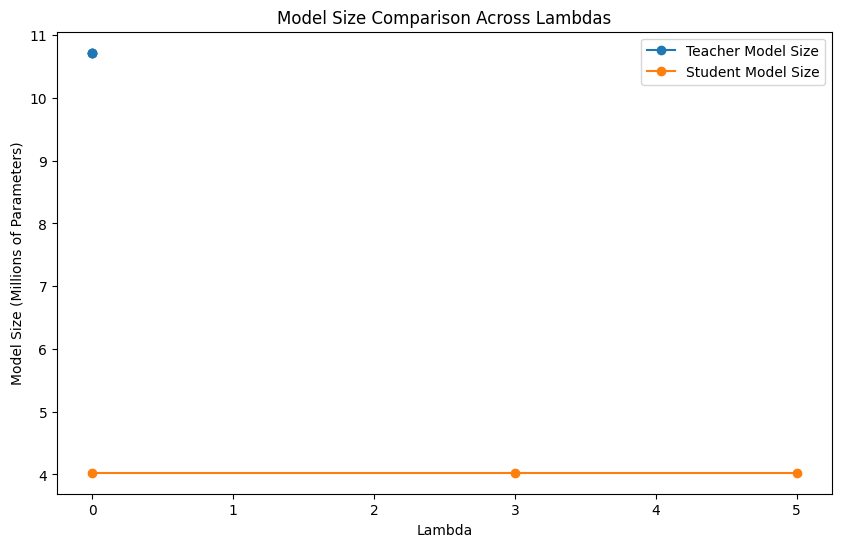

In [62]:
# Initialize lists to store model sizes
teacher_sizes = []
student_sizes = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the model sizes for each pair
        teacher_size = lambda_results[(lmda_teacher, lmda_student)]['teacher_params'] / 1e6  # Convert to millions
        student_size = lambda_results[(lmda_teacher, lmda_student)]['student_params'] / 1e6
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append model sizes to the lists along with lambda values
    teacher_sizes.append((lmda_teacher, teacher_size))
    student_sizes.append((lmda_student, student_size))

# To plot, you might need to separate the lambda values and model sizes
teacher_lambdas, teacher_model_sizes = zip(*teacher_sizes)
student_lambdas, student_model_sizes = zip(*student_sizes)

print(teacher_lambdas, teacher_model_sizes)
print(student_lambdas, student_model_sizes)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_model_sizes, label='Teacher Model Size', marker='o')
plt.plot(student_lambdas, student_model_sizes, label='Student Model Size', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()
plt.show()

(0,) (0.027696847915649414,)
(0, 3, 5) (0.043256521224975586, 0.030232667922973633, 0.043700218200683594)


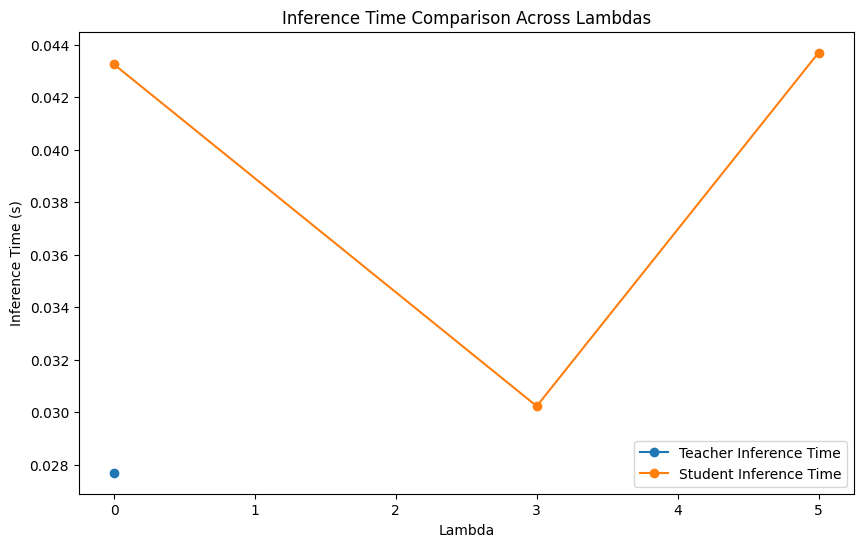

In [63]:
# Initialize dictionaries to store inference times for each lambda value
teacher_times = {}
student_times = {}

# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model for the current lambda
    # teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
    teacher_model_path = f'teacher_model_rkd_wider_lambda02.pth'
    teacher_model = torch.load(teacher_model_path)

    teacher_time, _ = compare_inference_time(teacher_model, None, testloader)
    teacher_times[lmda_teacher] = teacher_time  # Store the inference time for the teacher model

for lmda_student in lmda_list_student:
    # Load the student model for the current lambda
    # student_model_path = os.path.join(output_dir, f'student_model_rkd_wider_lambda{lmda_student}.pth')
    student_model_path = f'student_model_rkd_wider_lambda{lmda_student}.pth'
    student_model = torch.load(student_model_path)

    _, student_time = compare_inference_time(None, student_model, testloader)
    student_times[lmda_student] = student_time  # Store the inference time for the student model

# Prepare data for plotting
teacher_lambdas, teacher_inference_times = zip(*teacher_times.items())
student_lambdas, student_inference_times = zip(*student_times.items())

print(teacher_lambdas, teacher_inference_times )
print(student_lambdas, student_inference_times )

# plots
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_inference_times, label='Teacher Inference Time', marker='o')
plt.plot(student_lambdas, student_inference_times, label='Student Inference Time', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()
plt.show()

(0,) (0.12452049733518733,)
(0, 3, 5) (0.17548765846495434, 0.17366228389364088, 0.1490307400424532)


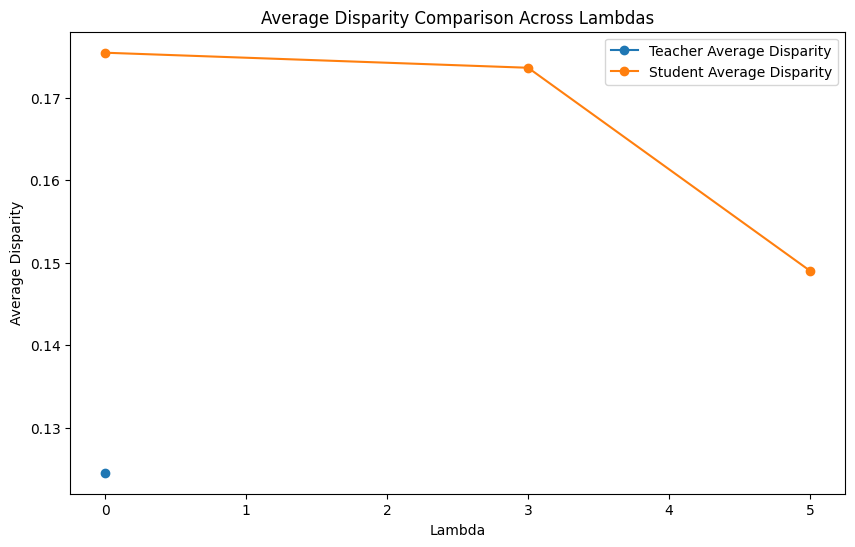

In [64]:
# Initialize lists to store disparity values
teacher_disparities = []
student_disparities = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if it's an integer key (indicating a lambda value for student)
    if isinstance(key, int):
        # Check and extract teacher disparity if it exists
        if 'teacher_mean_abs_val_disparity' in lambda_results[key]:
            teacher_disparity = lambda_results[key]['teacher_mean_abs_val_disparity']
            if isinstance(teacher_disparity, list):  # Assuming the disparity could be stored as a list
                teacher_disparity = teacher_disparity[0]
            teacher_disparities.append((key, teacher_disparity))

        # Extract student disparity
        if 'student_mean_abs_val_disparity' in lambda_results[key]:
            student_disparity = lambda_results[key]['student_mean_abs_val_disparity']
            student_disparities.append((key, student_disparity))

# Separate the lambda values and disparity values
teacher_lambdas, teacher_disparity_values = zip(*teacher_disparities) if teacher_disparities else ([], [])
student_lambdas, student_disparity_values = zip(*student_disparities) if student_disparities else ([], [])

print(teacher_lambdas, teacher_disparity_values)
print(student_lambdas, student_disparity_values)

# Plotting
plt.figure(figsize=(10, 6))
if teacher_disparities:
    plt.plot(teacher_lambdas, teacher_disparity_values, label='Teacher Average Disparity', marker='o')
if student_disparities:
    plt.plot(student_lambdas, student_disparity_values, label='Student Average Disparity', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()
plt.show()

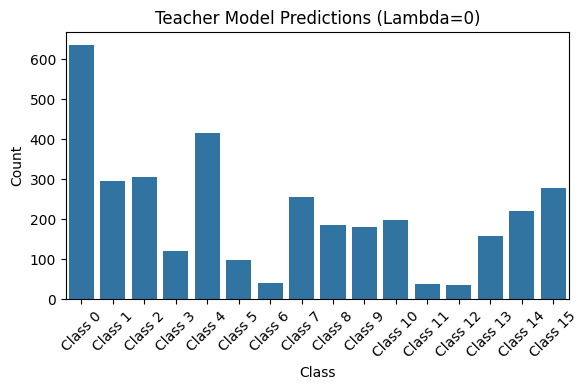

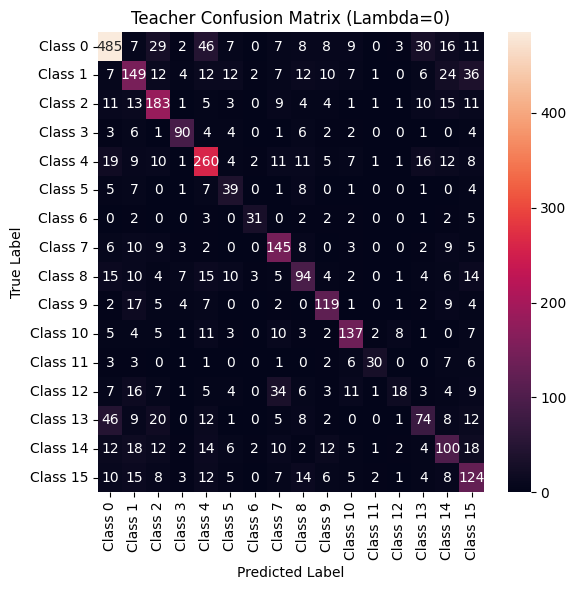

Classification Report - Teacher Model (Lambda=0)
              precision    recall  f1-score   support

     Class 0       0.76      0.73      0.74       668
     Class 1       0.51      0.50      0.50       301
     Class 2       0.60      0.67      0.63       272
     Class 3       0.74      0.73      0.73       124
     Class 4       0.62      0.69      0.66       377
     Class 5       0.40      0.53      0.45        74
     Class 6       0.78      0.62      0.69        50
     Class 7       0.57      0.72      0.63       202
     Class 8       0.51      0.48      0.49       194
     Class 9       0.66      0.69      0.67       173
    Class 10       0.69      0.69      0.69       199
    Class 11       0.77      0.50      0.61        60
    Class 12       0.49      0.14      0.22       129
    Class 13       0.47      0.37      0.41       198
    Class 14       0.45      0.45      0.45       220
    Class 15       0.45      0.55      0.49       224

    accuracy                   

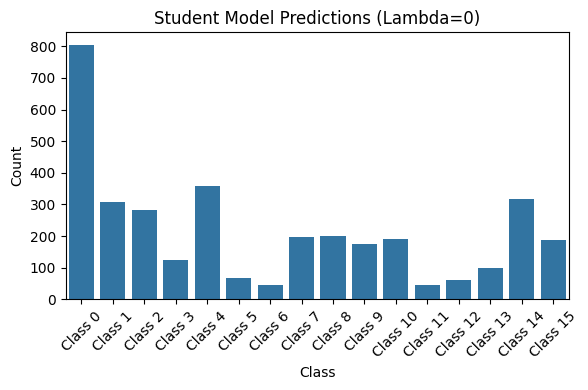

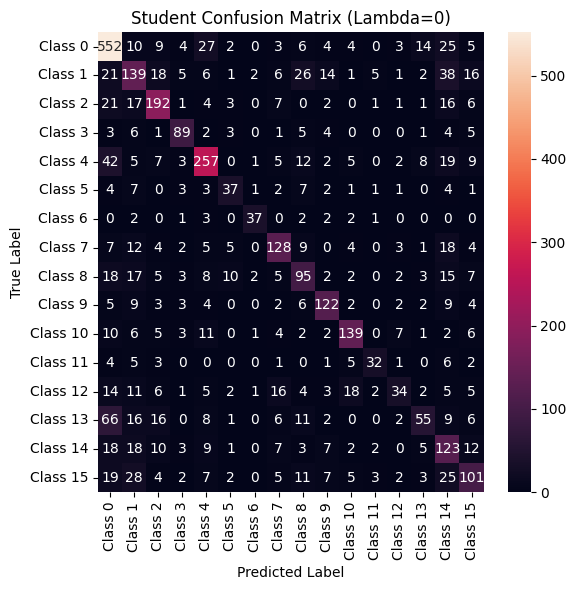

Classification Report - Student Model (Lambda=0)
              precision    recall  f1-score   support

     Class 0       0.69      0.83      0.75       668
     Class 1       0.45      0.46      0.46       301
     Class 2       0.68      0.71      0.69       272
     Class 3       0.72      0.72      0.72       124
     Class 4       0.72      0.68      0.70       377
     Class 5       0.55      0.50      0.52        74
     Class 6       0.82      0.74      0.78        50
     Class 7       0.65      0.63      0.64       202
     Class 8       0.48      0.49      0.48       194
     Class 9       0.69      0.71      0.70       173
    Class 10       0.73      0.70      0.71       199
    Class 11       0.68      0.53      0.60        60
    Class 12       0.56      0.26      0.36       129
    Class 13       0.56      0.28      0.37       198
    Class 14       0.39      0.56      0.46       220
    Class 15       0.53      0.45      0.49       224

    accuracy                   

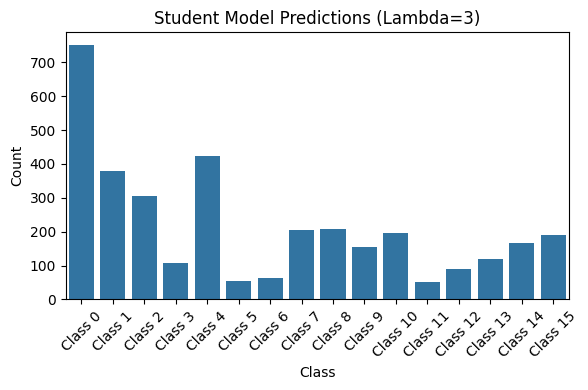

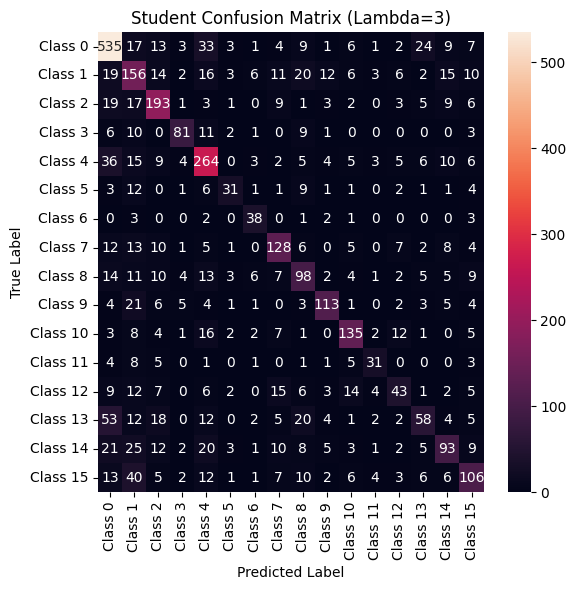

Classification Report - Student Model (Lambda=3)
              precision    recall  f1-score   support

     Class 0       0.71      0.80      0.75       668
     Class 1       0.41      0.52      0.46       301
     Class 2       0.63      0.71      0.67       272
     Class 3       0.76      0.65      0.70       124
     Class 4       0.62      0.70      0.66       377
     Class 5       0.58      0.42      0.49        74
     Class 6       0.59      0.76      0.67        50
     Class 7       0.62      0.63      0.63       202
     Class 8       0.47      0.51      0.49       194
     Class 9       0.73      0.65      0.69       173
    Class 10       0.69      0.68      0.69       199
    Class 11       0.60      0.52      0.55        60
    Class 12       0.47      0.33      0.39       129
    Class 13       0.49      0.29      0.37       198
    Class 14       0.56      0.42      0.48       220
    Class 15       0.56      0.47      0.51       224

    accuracy                   

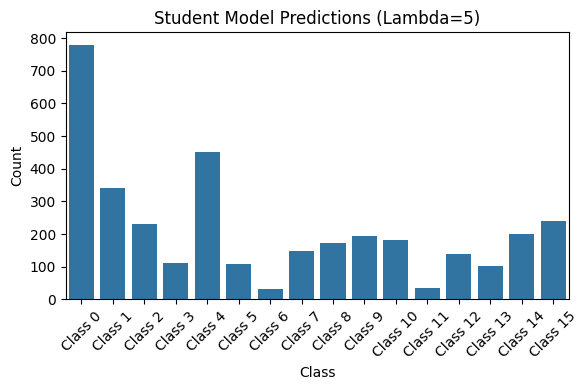

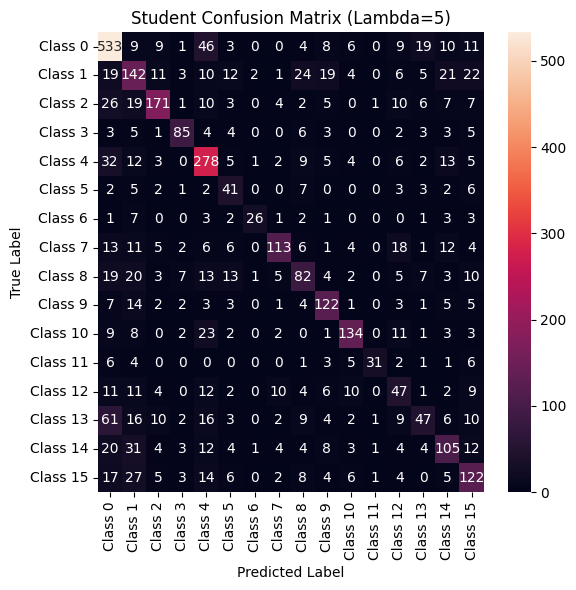

Classification Report - Student Model (Lambda=5)
              precision    recall  f1-score   support

     Class 0       0.68      0.80      0.74       668
     Class 1       0.42      0.47      0.44       301
     Class 2       0.74      0.63      0.68       272
     Class 3       0.76      0.69      0.72       124
     Class 4       0.62      0.74      0.67       377
     Class 5       0.38      0.55      0.45        74
     Class 6       0.84      0.52      0.64        50
     Class 7       0.77      0.56      0.65       202
     Class 8       0.48      0.42      0.45       194
     Class 9       0.63      0.71      0.66       173
    Class 10       0.74      0.67      0.71       199
    Class 11       0.89      0.52      0.65        60
    Class 12       0.34      0.36      0.35       129
    Class 13       0.46      0.24      0.31       198
    Class 14       0.52      0.48      0.50       220
    Class 15       0.51      0.54      0.53       224

    accuracy                   

In [65]:
def plot_distribution(predictions, class_names, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=predictions)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, predictions, class_names, title):
    cm = confusion_matrix(all_labels, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Function to generate predictions and compute metrics
def generate_predictions_and_metrics(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return all_labels, all_preds

# Loop over each lambda value for the teacher model
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model from the 'output_dir'
    # teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
    teacher_model_path = f'teacher_model_rkd_wider_lambda02.pth'
    teacher_model = torch.load(teacher_model_path)

    # Generate predictions for the teacher model
    all_labels, all_teacher_preds = generate_predictions_and_metrics(teacher_model, testloader)

    # Plot distribution and confusion matrix for the teacher model
    plot_distribution(all_teacher_preds, class_names_new, f'Teacher Model Predictions (Lambda={lmda_teacher})')
    plot_confusion_matrix(all_labels, all_teacher_preds, class_names_new, f'Teacher Confusion Matrix (Lambda={lmda_teacher})')

    # Print classification report for the teacher model
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda_teacher})')
    print(teacher_report)

# Loop over each lambda value for the student model
for lmda_student in lmda_list_student:
    # Load the student model from the 'output_dir'
    # student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
    student_model_path = f'student_model_rkd_wider_lambda{lmda_student}.pth'
    student_model = torch.load(student_model_path)

    # Generate predictions for the student model
    all_labels, all_student_preds = generate_predictions_and_metrics(student_model, testloader)

    # Plot distribution and confusion matrix for the student model
    plot_distribution(all_student_preds, class_names_new, f'Student Model Predictions (Lambda={lmda_student})')
    plot_confusion_matrix(all_labels, all_student_preds, class_names_new, f'Student Confusion Matrix (Lambda={lmda_student})')

    # Print classification report for the student model
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Student Model (Lambda={lmda_student})')
    print(student_report)

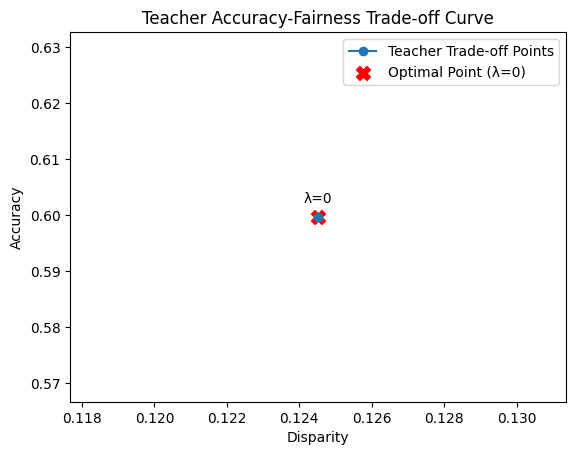

Optimal Lambda for Teacher: 0
Optimal Bias/Disparity for Teacher: 0.12452049733518733
Optimal Accuracy for Teacher: 0.5997113997113998
Optimal Weighted Ratio for Teacher: 0.53


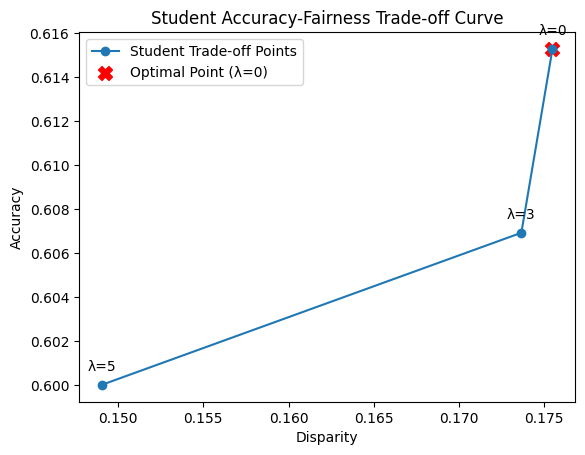

Optimal Lambda for Student: 0
Optimal Bias/Disparity for Student: 0.17548765846495434
Optimal Accuracy for Student: 0.6152958152958153
Optimal Weighted Ratio for Student: 0.52


In [66]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    bias_values = []
    accuracy_values = []

    if model_type == 'teacher':
        for lmda in lambdas:
            if lmda in model_results and 'teacher_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['teacher_mean_abs_val_disparity'][0])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[0] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][0])
        model_name = "Teacher"
    elif model_type == 'student':
        for lmda in lambdas:
            if lmda in model_results and 'student_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['student_mean_abs_val_disparity'])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[1] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][1])
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")


    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")
    
# Plot for Teacher
plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list_teacher)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)


In [67]:
def compare_performance_metrics_for_demo(teacher, student, dataloader):
    teacher.eval()
    student.eval()

    detailed_info = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        # Assuming gender or other attributes are part of 'target'
        attributes = batch['target'].to(device)  

        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)

        teacher_preds = torch.argmax(teacher_outputs, dim=1)
        student_preds = torch.argmax(student_outputs, dim=1)

        for i in range(inputs.size(0)):
            if teacher_preds[i] != labels[i] and student_preds[i] == labels[i]:
                info = {
                    'image': inputs[i],
                    'actual_class': labels[i].item(),
                    'teacher_pred_class': teacher_preds[i].item(),
                    'student_pred_class': student_preds[i].item(),
                    'actual_attribute': attributes[i].item(),  # Modify based on your dataset
                    # If your model also predicts attributes, include them here
                }
                detailed_info.append(info)

    return detailed_info

In [68]:
def plot_images_with_details(info_list, rows=5, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(rows * cols):
        if i < len(info_list):
            data = info_list[i]
            image = data['image']
            actual_class = data['actual_class']
            teacher_pred_class = data['teacher_pred_class']
            student_pred_class = data['student_pred_class']
            actual_attribute = round(data['actual_attribute'], 2)  # Round to 2 decimal places

            # Normalize the image for display
            image_display = image.cpu().numpy().transpose(1, 2, 0)
            image_display = (image_display - image_display.min()) / (image_display.max() - image_display.min())

            title = f'Actual: Class {actual_class}, Attr {actual_attribute}\n' + \
                    f'Teacher: Class {teacher_pred_class}\n' + \
                    f'Student: Class {student_pred_class}'

            axes[i].imshow(image_display)
            axes[i].set_title(title)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()


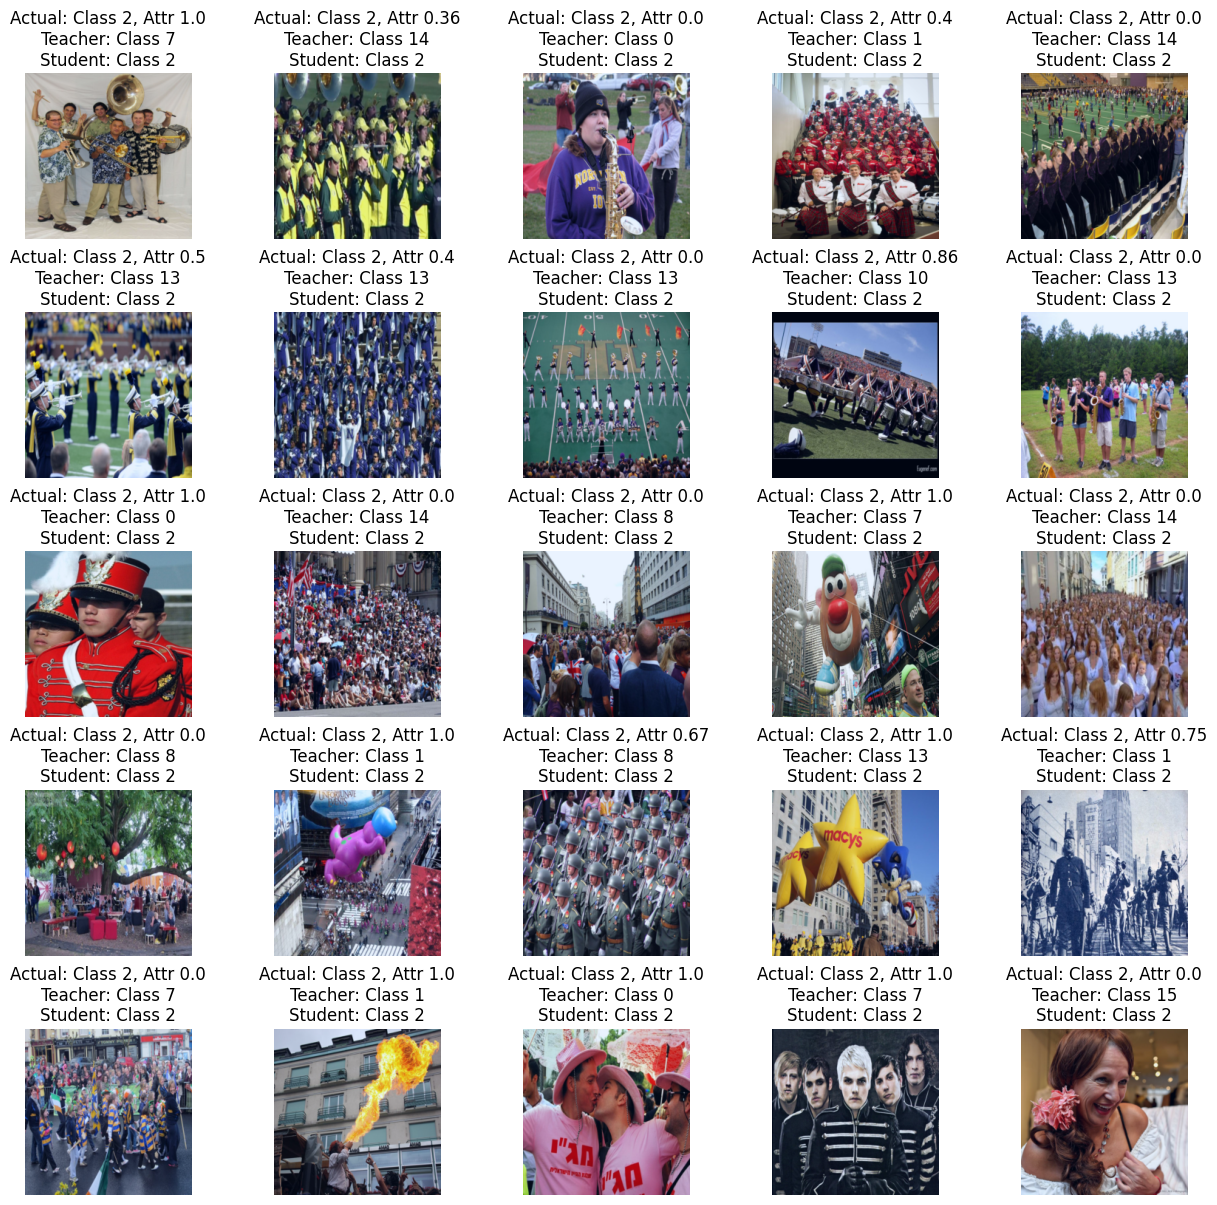

In [69]:
# Get detailed info where student is correct and teacher is wrong
detailed_info = compare_performance_metrics_for_demo(teacher_model, student_model, testloader)

# Display images with details
plot_images_with_details(detailed_info)